# Transformers for Mass Spectrometry Prediction

We explore three transformer families for EI mass spectrum prediction on the $\sqrt{\cdot}$ scale: an encoder-only model (SpectraFormer), a 1D ViT, and a linear-attention variant for long sequences.

## Problem setup
- Input features: $\mathbf{x}\in\mathbb{R}^{7137}$
- Target spectrum: $\mathbf{y}\in\mathbb{R}_{\ge 0}^{500}$ with $\mathbf{y}=\sqrt{\tilde{\mathbf{y}}}$
- Primary metric: cosine similarity; secondary: MSE/MAE/$R^2$/peak F1; regional m/z analysis

```mermaid
flowchart LR
  X["Features x (7137)"] --> S["Scale"]
  S --> T{"Transformer model"}
  T --> Y["ŷ ∈ R_+^{500}"]
  Y --> M["Metrics: cosine/F1/MSE"]
  Y --> R["Regional m/z"]
```

## Implemented architectures
- **SpectraFormer**: encoder-only with learned queries per m/z bin
- **ViT-1D**: patch embeddings along m/z
- **LinearAttention-1D**: FAVOR-style linear attention (O(Ld))

Key techniques: ALiBi/positional priors, sparsity-aware losses, MPS-friendly training (fp16 autocast, grad accumulation).

Goal: exceed 0.8063 cosine while improving high m/z F1.

## 0. Environment Setup & MPS Configuration

Configure PyTorch for optimal MPS performance with transformer models.

In [30]:
# Standard library imports
import os
import json
import pickle
import math
import warnings
import logging
import io
import random
import time
from typing import Dict, Any, Tuple, List, Optional, Union
from collections import defaultdict
from dataclasses import dataclass
from abc import ABC, abstractmethod
from contextlib import nullcontext

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.special import expit as sigmoid
from scipy.optimize import minimize
from scipy.ndimage import uniform_filter1d

# Machine learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Deep learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.nn.utils import weight_norm

# Chemistry imports (optional)
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import rdMolDraw2D
    RDKIT_AVAILABLE = True
    print("RDKit available for molecular structure visualization")
except ImportError:
    RDKIT_AVAILABLE = False
    print("Warning: RDKit not available. Molecular structure features will be limited.")

# Configure environment
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# MPS-optimized device configuration
torch.backends.cuda.matmul.allow_tf32 = False
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    AMP = torch.autocast("mps", dtype=torch.float16)
    print("Using MPS device with fp16 autocast")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    AMP = torch.autocast("cuda", dtype=torch.float16)
    print("Using CUDA device with fp16 autocast")
else:
    DEVICE = torch.device("cpu")
    AMP = nullcontext()
    print("Using CPU device (no autocast)")

torch.set_float32_matmul_precision("high")  # Safe on MPS

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Colorblind-friendly Okabe–Ito palette
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Configure plotting defaults
plt.rcParams.update({
    'figure.figsize': (12, 10),
    'figure.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.grid': True,
    'grid.alpha': 0.3
})

print(f"PyTorch version: {torch.__version__}")
print(f"Environment setup complete")

RDKit available for molecular structure visualization
Using CUDA device with fp16 autocast
PyTorch version: 2.5.1
Environment setup complete


## 1. Configuration Management

- Paths, data transform $y=\sqrt{\tilde y}$, training hyperparameters (warmup, grad accumulation)
- Loss weights (MSE, cosine, sparsity; optional top-k ranking and KL alignment)
- Evaluation: `mz_step`, `peak_threshold`
- Architecture configs for SpectraFormer, ViT1D, LinearAttn1D

```mermaid
flowchart LR
  C["Config"] --> T["Training (warmup, grad-accum)"]
  C --> L["Loss weights"]
  C --> E["Eval settings"]
  C --> A["Arch params"]
```

In [31]:
@dataclass
class PathConfig:
    """Path configuration"""
    results_dir: str = '../data/results'
    models_dir: str = '../models/transformers'
    input_type: str = 'hpj'
    use_selected_data: bool = False
    
    @property
    def data_subdir(self) -> str:
        return 'selected' if self.use_selected_data else 'full_featurised'

@dataclass
class DataConfig:
    """Data processing configuration"""
    random_state: int = 42
    transform_sqrt: bool = True
    feature_scaling: bool = True
    target_sparsity: float = 0.744
    spectrum_dim: int = 500  # L = sequence length
    feature_dim: int = 7137

@dataclass
class TrainingConfig:
    """Training hyperparameters optimized for transformers"""
    batch_size: int = 32  # Reduced for MPS memory
    epochs: int = 100
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    early_stopping_patience: int = 10
    lr_scheduler_patience: int = 5
    lr_scheduler_factor: float = 0.5
    gradient_clip: float = 1.0
    eval_frequency: int = 5
    grad_accum: int = 2  # Gradient accumulation for effective batch size
    warmup_epochs: int = 5  # Transformer warmup

@dataclass
class LossConfig:
    """Loss function weights with transformer additions"""
    mse_weight: float = 1.0
    cosine_weight: float = 1.0
    sparsity_weight: float = 1e-4
    presence_weight: float = 0.5
    focal_gamma: float = 2.0
    topk_weight: float = 0.1  # Top-k ranking loss
    kl_weight: float = 0.05  # Distribution alignment
    presence_smooth: float = 0.05  # Label smoothing for presence

@dataclass
class EvaluationConfig:
    """Evaluation settings"""
    mz_step: int = 50
    max_mz: int = 1000
    peak_threshold: float = 0.01
    eval_frequency: int = 5

class Config:
    """Master configuration with transformer architectures"""
    def __init__(self):
        self.paths = PathConfig()
        self.data = DataConfig()
        self.training = TrainingConfig()
        self.loss = LossConfig()
        self.evaluation = EvaluationConfig()
        
        # Transformer architecture configs
        self.architectures = self._get_architecture_configs()
        
        # Create directories
        os.makedirs(self.paths.models_dir, exist_ok=True)
    
    def _get_architecture_configs(self) -> Dict:
        """Get transformer architecture configurations"""
        return {
            'SpectraFormer': {
                'd_model': 384,
                'heads': 6,
                'depth': 6,
                'drop': 0.1,
                'context_tokens': 8
            },
            'ViT1D': {
                'd_model': 512,
                'heads': 8,
                'depth': 8,
                'patch_size': 5,
                'drop': 0.1
            },
            'LinearAttn1D': {
                'd_model': 320,
                'heads': 5,
                'depth': 10,
                'feature_map': 'elu'
            }
        }

# Initialize configuration
CONFIG = Config()
print(f"Configuration loaded. Models will be saved to: {CONFIG.paths.models_dir}")
print(f"Number of transformer architectures: {len(CONFIG.architectures)}")

Configuration loaded. Models will be saved to: ../models/transformers
Number of transformer architectures: 3


## 2. Data Management with Sequence Adapter

- JSONL loading, feature scaling, $\sqrt{\cdot}$ transform for $y$
- `SequenceAdapter` presents spectra as $L=500$ token positions for attention

```mermaid
flowchart LR
  JSONL["JSONL"] --> Load["Load (X,y)"]
  Load --> Scale["Scale X; √-transform y"]
  Scale --> Seq["SequenceAdapter (L=500)"]
  Seq --> DL["DataLoaders"]
```

In [32]:
class DataManager:
    """Handles all data loading and preprocessing operations"""
    
    def __init__(self, config: Config):
        self.config = config
        self.scaler = None
        self.datasets = {}
        self.data_loaders = {}
        
    def get_data_paths(self) -> Dict[str, str]:
        """Get paths to data files"""
        input_type_dir = os.path.join(
            self.config.paths.results_dir, 
            self.config.paths.input_type
        )
        data_dir = os.path.join(input_type_dir, self.config.paths.data_subdir)
        
        return {
            'train': os.path.join(data_dir, 'train_data.jsonl'),
            'val': os.path.join(data_dir, 'val_data.jsonl'),
            'test': os.path.join(data_dir, 'test_data.jsonl')
        }
    
    def load_jsonl_data(self, filepath: str) -> Tuple[List, np.ndarray, np.ndarray]:
        """Load data from JSONL file"""
        smiles_list, features, targets = [], [], []
        
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            # Create synthetic data for demonstration
            n_samples = 100 if 'train' in filepath else 20
            n_features = 100
            n_bins = 500
            
            features = np.random.randn(n_samples, n_features)
            targets = np.zeros((n_samples, n_bins))
            
            for i in range(n_samples):
                n_peaks = np.random.randint(5, 20)
                peak_positions = np.random.choice(n_bins, n_peaks, replace=False)
                targets[i, peak_positions] = np.random.exponential(0.5, n_peaks)
            
            smiles_list = ['N/A'] * n_samples
            return smiles_list, features, targets
        
        with open(filepath, 'r') as f:
            for line in f:
                try:
                    record = json.loads(line)
                    smiles = record.get("smiles")
                    feat = record.get("features")
                    targ = record.get("target")
                    
                    if smiles and feat is not None and targ is not None:
                        smiles_list.append(smiles)
                        features.append(feat)
                        targets.append(targ)
                except:
                    continue
        
        return smiles_list, np.array(features), np.array(targets)
    
    def load_all_data(self) -> Tuple[Dict, Any]:
        """Load and preprocess all datasets"""
        print("Loading datasets...")
        
        paths = self.get_data_paths()
        
        for name, path in paths.items():
            smiles, X, y = self.load_jsonl_data(path)
            
            # Apply transformation
            if self.config.data.transform_sqrt and len(y) > 0:
                y = np.sqrt(y)
            
            self.datasets[name] = (smiles, X, y)
            print(f"{name.capitalize()}: {len(X)} samples")
        
        # Apply feature scaling
        if self.config.data.feature_scaling and len(self.datasets['train'][1]) > 0:
            self.scaler = StandardScaler()
            _, X_train, _ = self.datasets['train']
            self.scaler.fit(X_train)
            
            for name in self.datasets:
                smiles, X, y = self.datasets[name]
                if len(X) > 0:
                    X_scaled = self.scaler.transform(X)
                    self.datasets[name] = (smiles, X_scaled, y)
        
        # Update config with actual dimensions
        if len(self.datasets['train'][1]) > 0:
            self.config.data.feature_dim = self.datasets['train'][1].shape[1]
            self.config.data.spectrum_dim = self.datasets['train'][2].shape[1]
        
        return self.datasets, self.scaler
    
    def create_data_loaders(self) -> Dict[str, DataLoader]:
        """Create PyTorch data loaders optimized for MPS"""
        for name, (_, X, y) in self.datasets.items():
            if len(X) > 0:
                dataset = TensorDataset(
                    torch.from_numpy(X).float(),
                    torch.from_numpy(y).float()
                )
                
                self.data_loaders[name] = DataLoader(
                    dataset,
                    batch_size=self.config.training.batch_size,
                    shuffle=(name == 'train'),
                    num_workers=0,  # MPS compatibility
                    pin_memory=False  # MPS compatibility
                )
        
        return self.data_loaders
    
    def get_data_stats(self) -> pd.DataFrame:
        """Get statistics about loaded data"""
        stats = []
        for name, (_, X, y) in self.datasets.items():
            if len(X) > 0:
                stats.append({
                    'Dataset': name.capitalize(),
                    'Samples': len(X),
                    'Features': X.shape[1],
                    'Outputs': y.shape[1],
                    'Min Intensity': np.min(y),
                    'Max Intensity': np.max(y),
                    'Sparsity': np.mean(y == 0)
                })
        return pd.DataFrame(stats)


class SequenceAdapter:
    """Adapter to present spectrum as sequence for transformers"""
    
    def __init__(self, L: int):
        self.L = L  # Sequence length (500 bins)
        self.pos = torch.arange(L)
    
    def to_tokens(self, x_batch: torch.Tensor) -> torch.Tensor:
        """Convert features to tokens (B, 7137) -> (B, 1, 7137) for single molecule token"""
        return x_batch
    
    def target_tokens(self, y_batch: torch.Tensor) -> torch.Tensor:
        """Convert targets to sequence format (B, 500) -> (B, L, 1)"""
        return y_batch.unsqueeze(-1)
    
    def positions(self, device: torch.device) -> torch.Tensor:
        """Get position indices for m/z bins"""
        return self.pos.to(device)


# Initialize data manager and sequence adapter
data_manager = DataManager(CONFIG)
datasets, scaler = data_manager.load_all_data()
data_loaders = data_manager.create_data_loaders()
sequence_adapter = SequenceAdapter(CONFIG.data.spectrum_dim)

# Display data statistics
print("\nData Statistics:")
print(data_manager.get_data_stats().to_string(index=False))

# Store commonly used variables
test_smiles, X_test, y_test = datasets['test']
_, X_train, y_train = datasets['train']
_, X_val, y_val = datasets['val']

input_dim = CONFIG.data.feature_dim
output_dim = CONFIG.data.spectrum_dim

print(f"\nModel dimensions: input={input_dim}, output={output_dim}")
print(f"Sequence length L={output_dim} (m/z bins)")

Loading datasets...
Train: 2176 samples
Val: 272 samples
Test: 272 samples

Data Statistics:
Dataset  Samples  Features  Outputs  Min Intensity  Max Intensity  Sparsity
  Train     2176      7137      500            0.0            1.0  0.745159
    Val      272      7137      500            0.0            1.0  0.740066
   Test      272      7137      500            0.0            1.0  0.736265

Model dimensions: input=7137, output=500
Sequence length L=500 (m/z bins)


## 3. Transformer Utilities

Positional encodings (sinusoidal/learned, ALiBi), patch embedding for 1D ViT, and standard transformer blocks.

```mermaid
flowchart TD
  Pos["Positional encodings"] --> Use
  ALiBi["ALiBi biases"] --> Use
  Patch["1D Patcher"] --> Use
  Block["TransformerBlock (MHA + FFN)"] --> Use
  Use["Architectures"]
```

In [33]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformers"""
    
    def __init__(self, d_model: int, max_len: int = 1000, encoding_type: str = 'sinusoidal'):
        super().__init__()
        self.encoding_type = encoding_type
        
        if encoding_type == 'sinusoidal':
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len).unsqueeze(1).float()
            div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                               -(math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pe', pe)
        elif encoding_type == 'learnable':
            self.pe = nn.Parameter(torch.randn(max_len, d_model))
    
    def forward(self, seq_len: int) -> torch.Tensor:
        return self.pe[:seq_len]


class ALiBi(nn.Module):
    """Attention with Linear Biases (ALiBi) for positional encoding"""
    
    def __init__(self, num_heads: int, max_len: int = 1000):
        super().__init__()
        slopes = torch.tensor([2 ** (-8 * i / num_heads) for i in range(num_heads)])
        self.register_buffer('slopes', slopes.view(1, num_heads, 1, 1))
        
        # Create position matrix
        positions = torch.arange(max_len).unsqueeze(0) - torch.arange(max_len).unsqueeze(1)
        self.register_buffer('positions', positions.unsqueeze(0).unsqueeze(0))
    
    def forward(self, seq_len: int) -> torch.Tensor:
        return self.slopes * self.positions[:, :, :seq_len, :seq_len]


class Patcher1D(nn.Module):
    """1D patching for ViT-style transformers"""
    
    def __init__(self, patch_size: int, d_model: int, projection: str = 'conv'):
        super().__init__()
        self.patch_size = patch_size
        
        if projection == 'conv':
            self.projection = nn.Conv1d(1, d_model, kernel_size=patch_size, stride=patch_size)
        else:  # 'mean'
            self.projection = nn.Linear(patch_size, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Patchify input: (B, L) -> (B, L/p, d_model)"""
        B, L = x.shape
        if hasattr(self.projection, 'weight'):
            if isinstance(self.projection, nn.Conv1d):
                x = x.unsqueeze(1)  # (B, 1, L)
                x = self.projection(x)  # (B, d_model, L/p)
                x = x.transpose(1, 2)  # (B, L/p, d_model)
            else:
                # Reshape to patches
                x = x.view(B, L // self.patch_size, self.patch_size)
                x = self.projection(x)
        return x


class TransformerBlock(nn.Module):
    """Standard transformer block with pre-norm"""
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1, 
                 ffn_mult: int = 4):
        super().__init__()
        # Multi-head attention
        self.attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * ffn_mult),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * ffn_mult, d_model),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Pre-norm attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=mask, need_weights=False)
        x = x + attn_out
        
        # Pre-norm FFN
        x_norm = self.norm2(x)
        x = x + self.ffn(x_norm)
        
        return x


class DepthwiseConv1D(nn.Module):
    """Depthwise 1D convolution for Conformer"""
    
    def __init__(self, channels: int, kernel_size: int, padding: str = 'same'):
        super().__init__()
        self.padding = (kernel_size - 1) // 2 if padding == 'same' else 0
        self.conv = nn.Conv1d(
            channels, channels, kernel_size, 
            padding=self.padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply depthwise conv: (B, L, C) -> (B, L, C)"""
        x = x.transpose(1, 2)  # (B, C, L)
        x = self.conv(x)
        x = self.norm(x)
        x = x.transpose(1, 2)  # (B, L, C)
        return x


print("Transformer utilities initialized")
print(f"Available components: PositionalEncoding, ALiBi, Patcher1D, TransformerBlock, DepthwiseConv1D")

Transformer utilities initialized
Available components: PositionalEncoding, ALiBi, Patcher1D, TransformerBlock, DepthwiseConv1D


## 4. Extended Loss Functions for Transformers

Total loss combines base criteria with optional transformer-specific terms on the $\sqrt{\cdot}$ scale:

- MSE: $$\mathcal{L}_{\mathrm{mse}}=\tfrac{1}{B}\sum_b(\hat y_b-y_b)^2$$
- Cosine: $$\mathcal{L}_{\mathrm{cos}}=1-\tfrac{\langle y,\hat y\rangle}{\|y\|_2\,\|\hat y\|_2+\varepsilon}$$
- Sparsity: $$\mathcal{L}_{\mathrm{sp}}=\tfrac{1}{B}\sum_b|\hat y_b|$$
- Top-k ranking: encourages ordering on true top peaks
- KL alignment: matches normalized intensity distributions
- Presence BCE (if used by hierarchies)

$$\mathcal{L}=w_{m}\mathcal{L}_{\mathrm{mse}}+w_{c}\mathcal{L}_{\mathrm{cos}}+w_{s}\mathcal{L}_{\mathrm{sp}}+w_{k}\mathcal{L}_{\mathrm{topk}}+w_{kl}\mathcal{L}_{\mathrm{kl}}+w_{p}\mathcal{L}_{\mathrm{pres}}$$

In [34]:
class MetricsCalculator:
    """Handles all metric calculations"""
    
    @staticmethod
    def cosine_similarity_batch(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, np.ndarray]:
        """Calculate cosine similarity for a batch"""
        similarities = []
        for i in range(len(y_true)):
            true_spec = y_true[i]
            pred_spec = y_pred[i]
            
            if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
                cos_sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
            else:
                cos_sim = 1 - cosine(true_spec, pred_spec)
            
            similarities.append(cos_sim if not np.isnan(cos_sim) else 0)
        
        return np.mean(similarities), np.array(similarities)
    
    @staticmethod
    def weighted_dot_product(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
        """Calculate weighted dot product (WDP) score."""
        weights = y_true + eps
        numerator = np.sum(weights * y_true * y_pred)
        denominator = np.sum(weights * y_true * y_true) + eps
        return numerator / denominator
    
    @staticmethod
    def peak_detection_metrics(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.01) -> Dict:
        """Calculate peak detection metrics"""
        # Normalize to relative intensities
        y_true_norm = y_true / (np.max(y_true, axis=1, keepdims=True) + 1e-8)
        y_pred_norm = y_pred / (np.max(y_pred, axis=1, keepdims=True) + 1e-8)
        
        # Binary masks for peaks
        true_peaks = y_true_norm > threshold
        pred_peaks = y_pred_norm > threshold
        
        # Calculate metrics
        tp = np.sum(true_peaks & pred_peaks)
        fp = np.sum(~true_peaks & pred_peaks)
        fn = np.sum(true_peaks & ~pred_peaks)
        
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_peaks': np.sum(true_peaks),
            'pred_peaks': np.sum(pred_peaks),
            'tp': tp,
            'fp': fp,
            'fn': fn
        }
    
    @staticmethod
    def cosine_similarity_by_mz_range(y_true: np.ndarray, y_pred: np.ndarray, config: Config) -> Dict:
        """Calculate cosine similarity by m/z range."""
        spectrum_length = y_true.shape[1]
        step_size = config.evaluation.mz_step
        max_mz = min(config.evaluation.max_mz, spectrum_length)
        
        mz_ranges = {}
        for start in range(0, max_mz, step_size):
            end = min(start + step_size, max_mz)
            range_key = f"{start}-{end}"
            
            y_true_range = y_true[:, start:end]
            y_pred_range = y_pred[:, start:end]
            
            # Calculate cosine similarities
            similarities = []
            for i in range(len(y_true)):
                true_spec = y_true_range[i]
                pred_spec = y_pred_range[i]
                
                if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
                    sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
                else:
                    sim = 1 - cosine(true_spec, pred_spec)
                similarities.append(sim)
            
            mean_sim = np.mean(similarities)
            stat_uncertainty = np.std(similarities) / np.sqrt(len(similarities)) if len(similarities) > 1 else 0
            model_uncertainty = 0
            
            # Peak counting
            true_peaks = np.sum(y_true_range > config.evaluation.peak_threshold)
            pred_peaks = np.sum(y_pred_range > config.evaluation.peak_threshold)
            
            # Coverage
            non_zero_samples = np.sum(np.sum(y_true_range, axis=1) > 0)
            coverage = non_zero_samples / len(y_true) * 100
            
            mz_ranges[range_key] = {
                'mean_similarity': mean_sim,
                'stat_uncertainty': stat_uncertainty,
                'model_uncertainty': model_uncertainty,
                'coverage': coverage,
                'avg_true_peaks_per_spectrum': true_peaks / len(y_true),
                'avg_pred_peaks_per_spectrum': pred_peaks / len(y_true)
            }
        
        return mz_ranges
    
    @staticmethod
    def comprehensive_evaluation(y_true: np.ndarray, y_pred: np.ndarray, 
                                config: Config, model_name: str = "Model") -> Dict:
        """Comprehensive evaluation of predictions"""
        # Ensure non-negative
        y_pred = np.maximum(y_pred, 0)
        
        # Calculate all metrics
        cosine_mean, cosine_all = MetricsCalculator.cosine_similarity_batch(y_true, y_pred)
        peak_metrics = MetricsCalculator.peak_detection_metrics(
            y_true, y_pred, config.evaluation.peak_threshold
        )
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        # Sparsity analysis
        true_sparsity = np.mean(y_true == 0)
        pred_sparsity = np.mean(y_pred < config.evaluation.peak_threshold)
        
        # Regional analysis
        mz_range_sims = MetricsCalculator.cosine_similarity_by_mz_range(y_true, y_pred, config)
        
        results = {
            'cosine': cosine_mean,
            'cosine_similarity': cosine_mean,
            'individual_cos_sims': cosine_all,
            'peak_metrics': peak_metrics,
            'mse': mse,
            'r2': r2,
            'mae': mae,
            'true_sparsity': true_sparsity,
            'pred_sparsity': pred_sparsity,
            'mz_range_sims': mz_range_sims,
            'y_true': y_true,
            'y_pred': y_pred
        }
        
        # Print summary
        print(f"\n{model_name} Performance:")
        print(f"  Cosine Similarity: {cosine_mean:.4f}")
        print(f"  MSE: {mse:.4f}, R²: {r2:.4f}")
        print(f"  Peak Detection - Precision: {peak_metrics['precision']:.4f}, "
              f"Recall: {peak_metrics['recall']:.4f}, F1: {peak_metrics['f1_score']:.4f}")
        print(f"  Sparsity - True: {true_sparsity:.3f}, Pred: {pred_sparsity:.3f}")
        
        return results


class LossFunctions:
    """Extended loss functions for transformers"""
    
    @staticmethod
    def cosine_loss(pred: torch.Tensor, true: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
        """Cosine distance loss"""
        pred_norm = pred / (torch.norm(pred, dim=1, keepdim=True) + eps)
        true_norm = true / (torch.norm(true, dim=1, keepdim=True) + eps)
        return 1.0 - (pred_norm * true_norm).sum(dim=1).mean()
    
    @staticmethod
    def sparsity_loss(pred: torch.Tensor) -> torch.Tensor:
        """L1 regularization to encourage sparsity"""
        return pred.abs().mean()
    
    @staticmethod
    def topk_pairwise_hinge(pred: torch.Tensor, true: torch.Tensor, 
                            k: int = 20, margin: float = 0.05) -> torch.Tensor:
        """Top-k ranking loss to boost ordering of top peaks"""
        B, L = pred.shape
        
        # Get top-k indices from true
        _, true_topk_idx = torch.topk(true, k, dim=1)
        
        # Get predicted values at those positions
        pred_topk = torch.gather(pred, 1, true_topk_idx)
        
        # Pairwise ranking loss
        pred_diff = pred_topk.unsqueeze(2) - pred_topk.unsqueeze(1)
        true_topk = torch.gather(true, 1, true_topk_idx)
        true_diff = true_topk.unsqueeze(2) - true_topk.unsqueeze(1)
        
        # Hinge loss: if true_i > true_j, then pred_i should be > pred_j + margin
        ranking_loss = F.relu(margin - pred_diff * torch.sign(true_diff))
        
        return ranking_loss.mean()
    
    @staticmethod
    def distribution_alignment_kl(pred: torch.Tensor, true: torch.Tensor, 
                                 eps: float = 1e-8) -> torch.Tensor:
        """KL divergence between normalized intensity distributions"""
        # Normalize to probability distributions
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        true_norm = true / (true.sum(dim=1, keepdim=True) + eps)
        
        # KL divergence
        kl_div = F.kl_div(
            torch.log(pred_norm + eps), 
            true_norm, 
            reduction='batchmean'
        )
        
        return kl_div
    
    @staticmethod
    def presence_bce_smoothed(presence_pred: torch.Tensor, presence_true: torch.Tensor,
                            smooth: float = 0.05) -> torch.Tensor:
        """Label-smoothed BCE for presence prediction"""
        # Apply label smoothing
        presence_smooth = presence_true * (1 - smooth) + smooth / 2
        
        return F.binary_cross_entropy_with_logits(
            presence_pred, presence_smooth
        )
    
    @staticmethod
    def combined_loss(pred: torch.Tensor, true: torch.Tensor, config: Config,
                     presence_pred: torch.Tensor = None, 
                     presence_true: torch.Tensor = None) -> Tuple[torch.Tensor, Dict]:
        """Combined loss function with transformer extensions"""
        losses = {}
        
        # Main losses
        losses['mse'] = F.mse_loss(pred, true)
        losses['cosine'] = LossFunctions.cosine_loss(pred, true)
        losses['sparsity'] = LossFunctions.sparsity_loss(pred)
        
        # Transformer-specific losses
        if config.loss.topk_weight > 0:
            losses['topk'] = LossFunctions.topk_pairwise_hinge(pred, true)
        
        if config.loss.kl_weight > 0:
            losses['kl'] = LossFunctions.distribution_alignment_kl(pred, true)
        
        # Hierarchical loss if provided
        if presence_pred is not None and presence_true is not None:
            losses['presence'] = LossFunctions.presence_bce_smoothed(
                presence_pred, presence_true, config.loss.presence_smooth
            )
        
        # Combine losses
        total_loss = (
            config.loss.mse_weight * losses['mse'] +
            config.loss.cosine_weight * losses['cosine'] +
            config.loss.sparsity_weight * losses['sparsity']
        )
        
        if 'topk' in losses:
            total_loss += config.loss.topk_weight * losses['topk']
        
        if 'kl' in losses:
            total_loss += config.loss.kl_weight * losses['kl']
        
        if 'presence' in losses:
            total_loss += config.loss.presence_weight * losses['presence']
        
        # Convert to item() for logging
        loss_items = {k: v.item() for k, v in losses.items()}
        
        return total_loss, loss_items


# Initialize metrics and loss functions
metrics_calc = MetricsCalculator()
loss_fns = LossFunctions()
print("Extended loss functions initialized")
print(f"Available losses: MSE, Cosine, Sparsity, Top-k Ranking, KL Divergence, Presence BCE")

Extended loss functions initialized
Available losses: MSE, Cosine, Sparsity, Top-k Ranking, KL Divergence, Presence BCE


## 5. Transformer-Optimized Training Framework

MPS-friendly training loop with fp16 autocast and gradient accumulation.

```mermaid
flowchart TD
  B["Batches (X,y)"] --> AMP["fp16 autocast"]
  AMP --> F["Forward"]
  F --> L["Loss (base + topk + kl)"]
  L --> Acc["Grad accumulate (k)"]
  Acc --> Clip["Clip grads"]
  Clip --> Step["Optimizer step"]
  Step --> Eval["Periodic eval → cosine/F1"]
  Eval --> CKPT["Save best"]
```

In [35]:
class Trainer:
    """Unified training framework optimized for transformers"""
    
    def __init__(self, config: Config, device: torch.device):
        self.config = config
        self.device = device
        self.metrics_calc = MetricsCalculator()
        self.loss_fns = LossFunctions()
    
    def train_epoch(self, model: nn.Module, train_loader: DataLoader, 
                   optimizer: torch.optim.Optimizer, epoch: int, 
                   total_epochs: int) -> float:
        """Train for one epoch with gradient accumulation"""
        model.train()
        train_losses = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{total_epochs}")
        
        for step, (X_batch, y_batch) in enumerate(progress_bar):
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            # Mixed precision training
            with AMP:
                predictions = model(X_batch)
                loss, loss_components = self.loss_fns.combined_loss(
                    predictions, y_batch, self.config
                )
            
            # Gradient accumulation
            loss = loss / self.config.training.grad_accum
            loss.backward()
            
            if (step + 1) % self.config.training.grad_accum == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), self.config.training.gradient_clip
                )
                
                optimizer.step()
                optimizer.zero_grad()
            
            train_losses.append(loss.item() * self.config.training.grad_accum)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{train_losses[-1]:.4f}",
                'cos': f"{loss_components.get('cosine', 0):.4f}"
            })
        
        return np.mean(train_losses)
    
    def evaluate(self, model: nn.Module, val_loader: DataLoader) -> Dict:
        """Evaluate model on validation/test set"""
        model.eval()
        all_preds = []
        all_true = []
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                with AMP:
                    predictions = model(X_batch)
                    loss, _ = self.loss_fns.combined_loss(predictions, y_batch, self.config)
                
                val_losses.append(loss.item())
                
                all_preds.append(predictions.cpu().numpy())
                all_true.append(y_batch.cpu().numpy())
        
        y_pred = np.vstack(all_preds)
        y_true = np.vstack(all_true)
        
        # Calculate metrics
        results = self.metrics_calc.comprehensive_evaluation(
            y_true, y_pred, self.config, model.__class__.__name__
        )
        results['val_loss'] = np.mean(val_losses)
        
        return results
    
    def train_model(self, model: nn.Module, train_loader: DataLoader, 
                   val_loader: DataLoader, model_name: str) -> Tuple[Dict, float]:
        """Full training loop for a model with warmup"""
        
        # Setup optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=self.config.training.learning_rate,
            weight_decay=self.config.training.weight_decay
        )
        
        # Setup scheduler with warmup
        total_steps = len(train_loader) * self.config.training.epochs // self.config.training.grad_accum
        warmup_steps = len(train_loader) * self.config.training.warmup_epochs // self.config.training.grad_accum
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.config.training.learning_rate,
            total_steps=total_steps,
            pct_start=warmup_steps/total_steps,
            anneal_strategy='cos'
        )
        
        # Training history
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_cosine': [],
            'val_f1': [],
            'lr': []
        }
        
        best_val_cosine = -1
        patience_counter = 0
        
        print(f"\nTraining {model_name}...")
        print("=" * 60)
        
        for epoch in range(1, self.config.training.epochs + 1):
            # Training
            avg_train_loss = self.train_epoch(
                model, train_loader, optimizer, epoch, self.config.training.epochs
            )
            history['train_loss'].append(avg_train_loss)
            history['lr'].append(optimizer.param_groups[0]['lr'])
            
            # Step scheduler
            if epoch <= self.config.training.warmup_epochs:
                scheduler.step()
            
            # Validation
            if epoch % self.config.evaluation.eval_frequency == 0:
                val_results = self.evaluate(model, val_loader)
                
                history['val_loss'].append(val_results['val_loss'])
                history['val_cosine'].append(val_results['cosine_similarity'])
                history['val_f1'].append(val_results['peak_metrics']['f1_score'])
                
                # Early stopping check
                if val_results['cosine_similarity'] > best_val_cosine:
                    best_val_cosine = val_results['cosine_similarity']
                    patience_counter = 0
                    
                    # Save best model
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch,
                        'best_val_cosine': best_val_cosine,
                        'model_name': model_name
                    }, os.path.join(self.config.paths.models_dir, f'{model_name}_best.pth'))
                    
                    print(f"  New best model saved! (Cosine: {best_val_cosine:.4f})")
                else:
                    patience_counter += 1
                
                if patience_counter >= self.config.training.early_stopping_patience:
                    print(f"\nEarly stopping triggered at epoch {epoch}")
                    break
        
        print(f"\nTraining complete. Best validation cosine: {best_val_cosine:.4f}")
        
        # Load best model
        checkpoint = torch.load(
            os.path.join(self.config.paths.models_dir, f'{model_name}_best.pth'),
            weights_only=False
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        
        return history, best_val_cosine


# Initialize trainer
trainer = Trainer(CONFIG, DEVICE)
print("Transformer-optimized trainer initialized")
print(f"Gradient accumulation: {CONFIG.training.grad_accum}x")
print(f"Effective batch size: {CONFIG.training.batch_size * CONFIG.training.grad_accum}")

Transformer-optimized trainer initialized
Gradient accumulation: 2x
Effective batch size: 64


## 6. Standard Visualization Module 

Standard plotting suite for mass spectrometry models.

In [36]:
class StandardVisualizer:
    """Standard visualization suite for mass spectrometry models"""
    
    @staticmethod
    def plot_standard_2x2_diagnostic(results: Dict, model_name: str = "Model", show_uncertainties: bool = True):
        """Create standard 2x2 evaluation visualization.
        
        1. Cosine Similarity Distribution (Top-Left)
        2. Performance by m/z Range (Top-Right)
        3. Intensity Correlation with Violin Density (Bottom-Left)
        4. Peak Count Comparison (Bottom-Right)
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # ---------- Top-Left: Cosine Similarity Distribution ----------
        ax = axes[0, 0]
        ax.hist(results['individual_cos_sims'], bins=30, range=(0, 1),
                alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Count')
        ax.set_title(f'Cosine Similarity Distribution - {model_name}')
        ax.axvline(results['cosine'], color=PALETTE["vermillion"], linestyle='--', linewidth=2,
                   label=f"Mean: {results['cosine']:.4f}")
        ax.legend(frameon=False)
        ax.grid(alpha=0.3)
        
        # ---------- Top-Right: Performance by m/z with Uncertainties ----------
        ax = axes[0, 1]
        ranges = list(results['mz_range_sims'].keys())
        x_pos = np.arange(len(ranges))
        mean_sims = np.array([results['mz_range_sims'][r]['mean_similarity'] for r in ranges])
        stat_uncertainties = np.array([results['mz_range_sims'][r]['stat_uncertainty'] for r in ranges])
        model_uncertainties = np.array([results['mz_range_sims'][r]['model_uncertainty'] for r in ranges])
        
        # Uncertainty bands
        legend_handles = []
        if show_uncertainties:
            if np.any(stat_uncertainties > 0):
                stat_ci = 1.96 * stat_uncertainties
                stat_lower = np.clip(mean_sims - stat_ci, 0, 1)
                stat_upper = np.clip(mean_sims + stat_ci, 0, 1)
                ax.fill_between(x_pos, stat_lower, stat_upper,
                                facecolor='none', edgecolor=PALETTE["yellow"],
                                hatch='////', linewidth=1.2, zorder=3)
                ax.plot(x_pos, stat_lower, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
                ax.plot(x_pos, stat_upper, linestyle='--', color=PALETTE["yellow"], linewidth=1.2, zorder=4)
                legend_handles.append(Patch(facecolor='none', edgecolor=PALETTE["yellow"], hatch='////',
                                            label='Statistical Uncertainty (95% CI)'))
            if np.any(model_uncertainties > 0):
                model_sigma = 2.0 * model_uncertainties
                model_lower = np.clip(mean_sims - model_sigma, 0, 1)
                model_upper = np.clip(mean_sims + model_sigma, 0, 1)
                ax.fill_between(x_pos, model_lower, model_upper,
                                facecolor=PALETTE["purple"], alpha=0.18,
                                edgecolor=PALETTE["purple"], linewidth=0.8, zorder=1)
                ax.plot(x_pos, model_lower, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
                ax.plot(x_pos, model_upper, linestyle=':', color=PALETTE["purple"], linewidth=1.3, zorder=2)
                legend_handles.append(Patch(facecolor=PALETTE["purple"], alpha=0.18, edgecolor=PALETTE["purple"],
                                            label='Model Uncertainty (±2σ)'))
        
        ax.plot(x_pos, mean_sims, color=PALETTE["blue"], linewidth=2.5,
                label='Mean Cosine Similarity', marker='o', markersize=6, zorder=5)
        ax.set_xlabel('m/z Range')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'Performance by m/z Range - {model_name}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(ranges, rotation=45)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(alpha=0.3)
        if show_uncertainties and len(legend_handles) > 0:
            ax.legend(handles=legend_handles, loc='lower left', fontsize=9, frameon=False)
        
        # ---------- Bottom-Left: True vs Predicted Intensity with Violin Density ----------
        ax = axes[1, 0]
        y_true_flat = np.ravel(results['y_true']).astype(float)
        y_pred_flat = np.ravel(results['y_pred']).astype(float)
        m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
        x = y_true_flat[m]
        y = y_pred_flat[m]
        
        # Rotate to (u,v) coordinates for violin visualization
        root2 = np.sqrt(2.0)
        u = (x + y) / root2
        v = (y - x) / root2
        
        # Bin along diagonal and compute quantiles
        n_bins = 60
        u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
        u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
        widths_90 = np.full(n_bins, np.nan)
        widths_75 = np.full(n_bins, np.nan)
        widths_60 = np.full(n_bins, np.nan)
        min_count = 10
        
        for i in range(n_bins):
            mask = (u >= u_edges[i]) & (u < u_edges[i+1])
            if np.count_nonzero(mask) >= min_count:
                abs_v = np.abs(v[mask])
                widths_60[i] = np.percentile(abs_v, 60)
                widths_75[i] = np.percentile(abs_v, 75)
                widths_90[i] = np.percentile(abs_v, 90)
        
        # Interpolate and smooth
        def _interp_nan(a):
            xidx = np.arange(a.size)
            msk = ~np.isnan(a)
            if msk.sum() < 2:
                return np.nan_to_num(a, nan=0.0)
            return np.interp(xidx, xidx[msk], a[msk])
        
        def _smooth(a, k=5):
            if k <= 1: return a
            kernel = np.ones(k) / k
            return np.convolve(a, kernel, mode='same')
        
        widths_60 = _smooth(_interp_nan(widths_60), 5)
        widths_75 = _smooth(_interp_nan(widths_75), 5)
        widths_90 = _smooth(_interp_nan(widths_90), 5)
        
        def band_polygon(u_vals, w_vals):
            x_upper = (u_vals - w_vals) / root2
            y_upper = (u_vals + w_vals) / root2
            x_lower = (u_vals + w_vals) / root2
            y_lower = (u_vals - w_vals) / root2
            x_poly = np.r_[x_upper, x_lower[::-1]]
            y_poly = np.r_[y_upper, y_lower[::-1]]
            return x_poly, y_poly
        
        # Scatter points
        ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
                   edgecolors='none', alpha=1.0, zorder=0, rasterized=True)
        
        # Draw violin bands
        for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
            xp, yp = band_polygon(u_centers, w)
            ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)
        
        # Perfect prediction line
        max_val = 1.0  # Fixed to 1.0 for normalized intensities
        line_pp, = ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
                           linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel('True Intensity')
        ax.set_ylabel('Predicted Intensity')
        ax.set_title(f'Intensity Correlation - {model_name}')
        
        # Legend
        violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
        points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                               color=PALETTE["black"], label='All points')
        ax.legend(handles=[points_handle, violin_handle, line_pp], loc='lower right',
                  frameon=True, facecolor='white', framealpha=0.85, edgecolor='none', handlelength=2.2)
        ax.grid(alpha=0.25)
        
        # Metrics annotation
        text = f"R² = {results['r2']:.4f}\nMAE = {results['mae']:.4f}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=11,
                va='top', bbox=dict(boxstyle='round', facecolor='wheat',
                alpha=0.6, edgecolor='none'), zorder=5)
        
        # ---------- Bottom-Right: Peak Count Comparison ----------
        ax = axes[1, 1]
        true_peaks = [results['mz_range_sims'][r]['avg_true_peaks_per_spectrum'] for r in ranges]
        pred_peaks = [results['mz_range_sims'][r]['avg_pred_peaks_per_spectrum'] for r in ranges]
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, true_peaks, width, label='True',
                       color=PALETTE["green"], alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
        bars2 = ax.bar(x_pos + width/2, pred_peaks, width, label='Predicted',
                       color=PALETTE["blue"],  alpha=0.9, edgecolor=PALETTE["black"], linewidth=0.6)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                h = bar.get_height()
                if h > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.0f}',
                            ha='center', va='bottom', fontsize=12)
        
        ax.set_xlabel('m/z Range')
        ax.set_ylabel('Average Peaks per Spectrum')
        ax.set_title(f'Peak Count Comparison - {model_name}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(ranges, rotation=45)
        ax.legend(frameon=False)
        ax.grid(alpha=0.3)
        
        plt.suptitle(f'Standard Diagnostic Suite: {model_name}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_random_spectrum_grid(results: Dict, test_smiles: List, n_examples: int = 4, model_name: str = "Model"):
        """Create 2x2 grid of random spectrum examples."""
        # Select random examples
        n_samples = len(results['y_true'])
        random_indices = np.random.choice(n_samples, min(n_examples, n_samples), replace=False)
        
        # Calculate metrics for selected examples
        selected_data = []
        for idx in random_indices:
            y_true = results['y_true'][idx]
            y_pred = results['y_pred'][idx]
            
            # Calculate cosine similarity
            if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
                cosine_sim = 1.0
            elif np.sum(y_true) == 0 or np.sum(y_pred) == 0:
                cosine_sim = 0.0
            else:
                cosine_sim = 1 - cosine(y_true, y_pred)
            
            # Calculate WDP score
            wdp_score = MetricsCalculator.weighted_dot_product(y_true, y_pred)
            
            # Get SMILES
            smiles = test_smiles[idx] if idx < len(test_smiles) else 'N/A'
            
            selected_data.append({
                'y_true': y_true,
                'y_pred': y_pred,
                'cosine_sim': cosine_sim,
                'wdp_score': wdp_score,
                'smiles': smiles,
                'index': idx
            })
        
        # Create figure
        fig = plt.figure(figsize=(20, 16))
        main_gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
        
        print(f"\nSelected random examples:")
        
        for i, data in enumerate(selected_data[:4]):
            print(f"  {i+1}. Index {data['index']}: Cosine={data['cosine_sim']:.4f}, WDP={data['wdp_score']:.4f}")
            
            # Calculate position in 2x2 grid
            row = i // 2
            col = i % 2
            
            # Create sub-gridspec for this molecule
            sub_gs = gridspec.GridSpecFromSubplotSpec(2, 1, main_gs[row, col], 
                                                     height_ratios=[1, 1], hspace=0)
            
            ax1 = fig.add_subplot(sub_gs[0])  # Experimental
            ax2 = fig.add_subplot(sub_gs[1])  # Predicted
            
            # Process data (convert from sqrt scale if needed)
            y_true_scaled = data['y_true'] ** 2 if CONFIG.data.transform_sqrt else data['y_true']
            y_pred_scaled = data['y_pred'] ** 2 if CONFIG.data.transform_sqrt else data['y_pred']
            
            # Normalize to 0-100 scale
            if np.max(y_true_scaled) > 0:
                y_true_percent = (y_true_scaled / np.max(y_true_scaled)) * 100
            else:
                y_true_percent = y_true_scaled
                
            if np.max(y_pred_scaled) > 0:
                y_pred_percent = (y_pred_scaled / np.max(y_pred_scaled)) * 100
            else:
                y_pred_percent = y_pred_scaled
            
            # Find non-zero peaks for x-axis range
            mz_values = np.arange(len(data['y_true']))
            threshold = 0.1
            true_nonzero = y_true_percent > threshold
            pred_nonzero = y_pred_percent > threshold
            
            all_nonzero = true_nonzero | pred_nonzero
            if np.any(all_nonzero):
                nonzero_indices = np.where(all_nonzero)[0]
                min_mz = nonzero_indices[0]
                max_mz = nonzero_indices[-1]
                mz_range = max_mz - min_mz
                padding = max(10, int(0.05 * mz_range))
                x_min = max(0, min_mz - padding)
                x_max = min(len(data['y_true']), max_mz + padding)
            else:
                x_min = 0
                x_max = min(500, len(data['y_true']))
            
            # Top panel: Experimental spectrum
            if np.any(true_nonzero):
                markerline, stemlines, baseline = ax1.stem(
                    mz_values[true_nonzero], 
                    y_true_percent[true_nonzero],
                    linefmt='b-', markerfmt=' ', basefmt=' '
                )
                stemlines.set_linewidth(1)
            
            ax1.set_ylabel('Intensity (%)', fontsize=10)
            ax1.text(0.5, 0.95, 'Experimental', transform=ax1.transAxes,
                     fontsize=11, ha='center', va='top')
            ax1.set_ylim(0, 110)
            ax1.grid(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.tick_params(bottom=False, labelbottom=False)
            
            # Bottom panel: Predicted spectrum (inverted)
            if np.any(pred_nonzero):
                markerline, stemlines, baseline = ax2.stem(
                    mz_values[pred_nonzero], 
                    -y_pred_percent[pred_nonzero],
                    linefmt='r-', markerfmt=' ', basefmt=' '
                )
                stemlines.set_linewidth(1)
            
            ax2.set_ylim(-110, 0)
            ax2.set_ylabel('Intensity (%)', fontsize=10)
            ax2.set_xlabel('m/z (Da)', fontsize=10)
            ax2.text(0.5, 0.05, 'Predicted', transform=ax2.transAxes,
                     fontsize=11, ha='center', va='bottom')
            
            # Format y-axis to show positive values
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{abs(x):.0f}'))
            ax2.grid(False)
            ax2.spines['top'].set_visible(False)
            ax2.axhline(y=0, color='black', linewidth=1)
            
            # Set x-axis limits
            ax1.set_xlim(x_min, x_max)
            ax2.set_xlim(x_min, x_max)
            
            # Add title with scores
            title = f"Cosine: {data['cosine_sim']:.3f}, WDP: {data['wdp_score']:.3f}"
            ax1.set_title(title, fontsize=11, fontweight='bold')
        
        # Add overall title
        fig.suptitle(f'Random Spectrum Examples - {model_name}', fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    @staticmethod
    def plot_deep_learning_training(history: Dict, model_name: str = "Neural Network"):
        """Create 2x2 deep learning training visualization."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Top-Left: Loss Curves
        ax = axes[0, 0]
        epochs = range(1, len(history['train_loss']) + 1)
        ax.plot(epochs, history['train_loss'], label='Train', color=PALETTE["blue"], linewidth=2, alpha=0.8)
        
        if history['val_loss']:
            val_epochs = np.array(range(CONFIG.evaluation.eval_frequency, 
                                        len(history['train_loss']) + 1, 
                                        CONFIG.evaluation.eval_frequency))
            val_epochs = val_epochs[:len(history['val_loss'])]
            ax.plot(val_epochs, history['val_loss'][:len(val_epochs)], 
                   label='Validation', color=PALETTE["orange"], linewidth=2, alpha=0.8, marker='o', markersize=5)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'{model_name} - Training and Validation Loss')
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        
        # Top-Right: Cosine Similarity
        ax = axes[0, 1]
        if history['val_cosine']:
            val_epochs = np.array(range(CONFIG.evaluation.eval_frequency, 
                                        len(history['train_loss']) + 1, 
                                        CONFIG.evaluation.eval_frequency))
            val_epochs = val_epochs[:len(history['val_cosine'])]
            ax.plot(val_epochs, history['val_cosine'][:len(val_epochs)], 
                   color=PALETTE["green"], linewidth=2, marker='o', markersize=6, label='Val Cosine')
            
            # Highlight best
            best_cosine_idx = np.argmax(history['val_cosine'])
            best_cosine = history['val_cosine'][best_cosine_idx]
            best_epoch = val_epochs[min(best_cosine_idx, len(val_epochs)-1)]
            ax.scatter([best_epoch], [best_cosine], color=PALETTE["vermillion"], s=100, zorder=5, 
                      label=f'Best: {best_cosine:.4f}')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Cosine Similarity')
        ax.set_title(f'{model_name} - Validation Cosine Similarity')
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
        
        # Bottom-Left: Peak Detection F1
        ax = axes[1, 0]
        if history['val_f1']:
            val_epochs = np.array(range(CONFIG.evaluation.eval_frequency, 
                                        len(history['train_loss']) + 1, 
                                        CONFIG.evaluation.eval_frequency))
            val_epochs = val_epochs[:len(history['val_f1'])]
            ax.plot(val_epochs, history['val_f1'][:len(val_epochs)], 
                   color=PALETTE["purple"], linewidth=2, marker='s', markersize=6, label='Val F1')
            
            # Highlight best
            best_f1_idx = np.argmax(history['val_f1'])
            best_f1 = history['val_f1'][best_f1_idx]
            best_epoch = val_epochs[min(best_f1_idx, len(val_epochs)-1)]
            ax.scatter([best_epoch], [best_f1], color=PALETTE["vermillion"], s=100, zorder=5,
                      label=f'Best: {best_f1:.4f}')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('F1 Score')
        ax.set_title(f'{model_name} - Peak Detection F1 Score')
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])
        
        # Bottom-Right: Learning Rate Schedule
        ax = axes[1, 1]
        if history['lr']:
            epochs = range(1, len(history['lr']) + 1)
            ax.plot(epochs, history['lr'], color=PALETTE["vermillion"], linewidth=2, 
                   marker='o', markersize=4)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.set_title(f'{model_name} - Learning Rate Schedule')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        
        # Overall title and layout
        plt.suptitle(f'Deep Learning Training Suite: {model_name}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()


# Initialize standard visualizer
visualizer = StandardVisualizer()
print("Standard visualizer initialized")

Standard visualizer initialized


## 7. Base Model Classes for Transformers

Shared base class for all transformer models.

In [37]:
class BaseModel(nn.Module, ABC):
    """Base class for all transformer models"""
    
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    @abstractmethod
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass
    
    def count_parameters(self) -> int:
        """Count trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def train_and_evaluate_model(model_class, config_name: str, display_name: str = None):
    """Train a transformer model and display all standard visualizations.
    
    Args:
        model_class: The model class to instantiate
        config_name: Name of the configuration in CONFIG.architectures
        display_name: Display name for the model (defaults to config_name)
    
    Returns:
        Dictionary with results
    """
    if display_name is None:
        display_name = config_name
    
    print("\n" + "="*60)
    print(f"TRAINING {display_name.upper()}")
    print("="*60)
    
    # Create model
    model = model_class(input_dim, output_dim, CONFIG.architectures[config_name]).to(DEVICE)
    print(f"Total parameters: {model.count_parameters():,}")
    
    # Train model
    history, best_cosine = trainer.train_model(
        model, data_loaders['train'], data_loaders['val'], display_name
    )
    
    # Test evaluation
    test_results = trainer.evaluate(model, data_loaders['test'])
    
    print("\n" + "-"*60)
    print("GENERATING STANDARD VISUALIZATIONS")
    print("-"*60)
    
    # 1. Standard 2x2 Diagnostic Plots
    print("\n1. Standard 2x2 Diagnostic Plots")
    visualizer.plot_standard_2x2_diagnostic(test_results, display_name, show_uncertainties=True)
    
    # 2. Random Spectrum Visualization
    print("\n2. Random Spectrum Examples (2x2 Grid)")
    visualizer.plot_random_spectrum_grid(test_results, test_smiles, n_examples=4, model_name=display_name)
    
    # 3. Deep Learning Training Plots
    print("\n3. Deep Learning Training History")
    visualizer.plot_deep_learning_training(history, display_name)
    
    # Package results
    results = {
        'model_name': display_name,
        'val_cosine': best_cosine,
        'test_cosine': test_results['cosine_similarity'],
        'test_results': test_results,
        'history': history
    }
    
    print(f"\n{display_name} evaluation complete!")
    print("="*60)
    
    return results


print("Base model framework initialized")

Base model framework initialized


## 8. SpectraFormer Architecture

Encoder-only with learned query tokens per m/z bin attending to molecule context.

```mermaid
flowchart TD
  X["Molecule x"] --> Enc["Linear → ReLU → Linear (d)"]
  Enc --> Scale["FiLM scale"]
  Q["Learned queries (L×d)"] --> Scale
  Scale --> Blocks["Transformer blocks (×depth)"]
  Blocks --> Norm["LayerNorm"]
  Norm --> Head["MLP → 1"]
  Head --> O["ŷ (L)"]
```


TRAINING SPECTRAFORMER
Total parameters: 13,879,681

Training SpectraFormer...


Epoch 5/100: 100%|██████████| 68/68 [00:04<00:00, 16.04it/s, loss=0.4751, cos=0.3909]



SpectraFormer Performance:
  Cosine Similarity: 0.6063
  MSE: 0.0094, R²: -0.1347
  Peak Detection - Precision: 0.4201, Recall: 0.9763, F1: 0.5874
  Sparsity - True: 0.740, Pred: 0.431
  New best model saved! (Cosine: 0.6063)


Epoch 10/100: 100%|██████████| 68/68 [00:04<00:00, 15.12it/s, loss=0.4422, cos=0.3607]



SpectraFormer Performance:
  Cosine Similarity: 0.6558
  MSE: 0.0096, R²: -0.0505
  Peak Detection - Precision: 0.5565, Recall: 0.9336, F1: 0.6973
  Sparsity - True: 0.740, Pred: 0.574
  New best model saved! (Cosine: 0.6558)


Epoch 15/100: 100%|██████████| 68/68 [00:04<00:00, 15.96it/s, loss=0.3761, cos=0.3006]



SpectraFormer Performance:
  Cosine Similarity: 0.6948
  MSE: 0.0087, R²: -0.0781
  Peak Detection - Precision: 0.5421, Recall: 0.9431, F1: 0.6885
  Sparsity - True: 0.740, Pred: 0.558
  New best model saved! (Cosine: 0.6948)


Epoch 20/100: 100%|██████████| 68/68 [00:03<00:00, 17.59it/s, loss=0.3178, cos=0.2469]



SpectraFormer Performance:
  Cosine Similarity: 0.7121
  MSE: 0.0082, R²: 0.0834
  Peak Detection - Precision: 0.5838, Recall: 0.9169, F1: 0.7134
  Sparsity - True: 0.740, Pred: 0.602
  New best model saved! (Cosine: 0.7121)


Epoch 25/100: 100%|██████████| 68/68 [00:04<00:00, 14.95it/s, loss=0.2489, cos=0.1851]



SpectraFormer Performance:
  Cosine Similarity: 0.7221
  MSE: 0.0079, R²: -0.1273
  Peak Detection - Precision: 0.5373, Recall: 0.9317, F1: 0.6815
  Sparsity - True: 0.740, Pred: 0.560
  New best model saved! (Cosine: 0.7221)


Epoch 30/100: 100%|██████████| 68/68 [00:05<00:00, 13.44it/s, loss=0.2179, cos=0.1677]



SpectraFormer Performance:
  Cosine Similarity: 0.7300
  MSE: 0.0078, R²: -0.0100
  Peak Detection - Precision: 0.5076, Recall: 0.9474, F1: 0.6610
  Sparsity - True: 0.740, Pred: 0.528
  New best model saved! (Cosine: 0.7300)


Epoch 35/100: 100%|██████████| 68/68 [00:04<00:00, 13.72it/s, loss=0.2240, cos=0.1710]



SpectraFormer Performance:
  Cosine Similarity: 0.7386
  MSE: 0.0078, R²: -0.0586
  Peak Detection - Precision: 0.5154, Recall: 0.9452, F1: 0.6671
  Sparsity - True: 0.740, Pred: 0.534
  New best model saved! (Cosine: 0.7386)


Epoch 40/100: 100%|██████████| 68/68 [00:05<00:00, 13.36it/s, loss=0.2045, cos=0.1509]



SpectraFormer Performance:
  Cosine Similarity: 0.7450
  MSE: 0.0080, R²: 0.0334
  Peak Detection - Precision: 0.5075, Recall: 0.9595, F1: 0.6639
  Sparsity - True: 0.740, Pred: 0.514
  New best model saved! (Cosine: 0.7450)


Epoch 45/100: 100%|██████████| 68/68 [00:04<00:00, 13.76it/s, loss=0.2288, cos=0.1737]



SpectraFormer Performance:
  Cosine Similarity: 0.7415
  MSE: 0.0084, R²: -0.3268
  Peak Detection - Precision: 0.4519, Recall: 0.9713, F1: 0.6168
  Sparsity - True: 0.740, Pred: 0.445


Epoch 50/100: 100%|██████████| 68/68 [00:05<00:00, 13.37it/s, loss=0.1800, cos=0.1342]



SpectraFormer Performance:
  Cosine Similarity: 0.7485
  MSE: 0.0082, R²: 0.0272
  Peak Detection - Precision: 0.5051, Recall: 0.9623, F1: 0.6625
  Sparsity - True: 0.740, Pred: 0.508
  New best model saved! (Cosine: 0.7485)


Epoch 55/100: 100%|██████████| 68/68 [00:05<00:00, 13.49it/s, loss=0.1776, cos=0.1302]



SpectraFormer Performance:
  Cosine Similarity: 0.7420
  MSE: 0.0086, R²: -0.1234
  Peak Detection - Precision: 0.5083, Recall: 0.9568, F1: 0.6639
  Sparsity - True: 0.740, Pred: 0.509


Epoch 60/100: 100%|██████████| 68/68 [00:05<00:00, 13.03it/s, loss=0.1751, cos=0.1239]



SpectraFormer Performance:
  Cosine Similarity: 0.7527
  MSE: 0.0080, R²: -0.0075
  Peak Detection - Precision: 0.4949, Recall: 0.9659, F1: 0.6545
  Sparsity - True: 0.740, Pred: 0.497
  New best model saved! (Cosine: 0.7527)


Epoch 65/100: 100%|██████████| 68/68 [00:04<00:00, 14.14it/s, loss=0.1305, cos=0.0924]



SpectraFormer Performance:
  Cosine Similarity: 0.7605
  MSE: 0.0079, R²: 0.0522
  Peak Detection - Precision: 0.5183, Recall: 0.9617, F1: 0.6736
  Sparsity - True: 0.740, Pred: 0.520
  New best model saved! (Cosine: 0.7605)


Epoch 70/100: 100%|██████████| 68/68 [00:05<00:00, 13.17it/s, loss=0.1378, cos=0.0954]



SpectraFormer Performance:
  Cosine Similarity: 0.7609
  MSE: 0.0079, R²: 0.0928
  Peak Detection - Precision: 0.5529, Recall: 0.9536, F1: 0.7000
  Sparsity - True: 0.740, Pred: 0.553
  New best model saved! (Cosine: 0.7609)


Epoch 75/100: 100%|██████████| 68/68 [00:04<00:00, 15.00it/s, loss=0.1335, cos=0.0952]



SpectraFormer Performance:
  Cosine Similarity: 0.7616
  MSE: 0.0078, R²: 0.1146
  Peak Detection - Precision: 0.5756, Recall: 0.9407, F1: 0.7142
  Sparsity - True: 0.740, Pred: 0.578
  New best model saved! (Cosine: 0.7616)


Epoch 80/100: 100%|██████████| 68/68 [00:04<00:00, 14.13it/s, loss=0.1309, cos=0.0922]



SpectraFormer Performance:
  Cosine Similarity: 0.7632
  MSE: 0.0077, R²: 0.1272
  Peak Detection - Precision: 0.5890, Recall: 0.9333, F1: 0.7223
  Sparsity - True: 0.740, Pred: 0.591
  New best model saved! (Cosine: 0.7632)


Epoch 85/100: 100%|██████████| 68/68 [00:04<00:00, 14.71it/s, loss=0.1208, cos=0.0894]



SpectraFormer Performance:
  Cosine Similarity: 0.7652
  MSE: 0.0081, R²: 0.0705
  Peak Detection - Precision: 0.5269, Recall: 0.9603, F1: 0.6804
  Sparsity - True: 0.740, Pred: 0.525
  New best model saved! (Cosine: 0.7652)


Epoch 90/100: 100%|██████████| 68/68 [00:05<00:00, 12.64it/s, loss=0.1570, cos=0.1087]



SpectraFormer Performance:
  Cosine Similarity: 0.7641
  MSE: 0.0076, R²: 0.1358
  Peak Detection - Precision: 0.6020, Recall: 0.9282, F1: 0.7303
  Sparsity - True: 0.740, Pred: 0.604


Epoch 95/100: 100%|██████████| 68/68 [00:04<00:00, 14.21it/s, loss=0.1282, cos=0.0945]



SpectraFormer Performance:
  Cosine Similarity: 0.7643
  MSE: 0.0079, R²: 0.0859
  Peak Detection - Precision: 0.5598, Recall: 0.9475, F1: 0.7038
  Sparsity - True: 0.740, Pred: 0.559


Epoch 100/100: 100%|██████████| 68/68 [00:05<00:00, 13.09it/s, loss=0.1277, cos=0.0897]



SpectraFormer Performance:
  Cosine Similarity: 0.7653
  MSE: 0.0078, R²: 0.0756
  Peak Detection - Precision: 0.5168, Recall: 0.9659, F1: 0.6733
  Sparsity - True: 0.740, Pred: 0.515
  New best model saved! (Cosine: 0.7653)

Training complete. Best validation cosine: 0.7653

SpectraFormer Performance:
  Cosine Similarity: 0.7519
  MSE: 0.0061, R²: -0.5917
  Peak Detection - Precision: 0.5277, Recall: 0.9675, F1: 0.6830
  Sparsity - True: 0.736, Pred: 0.518

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


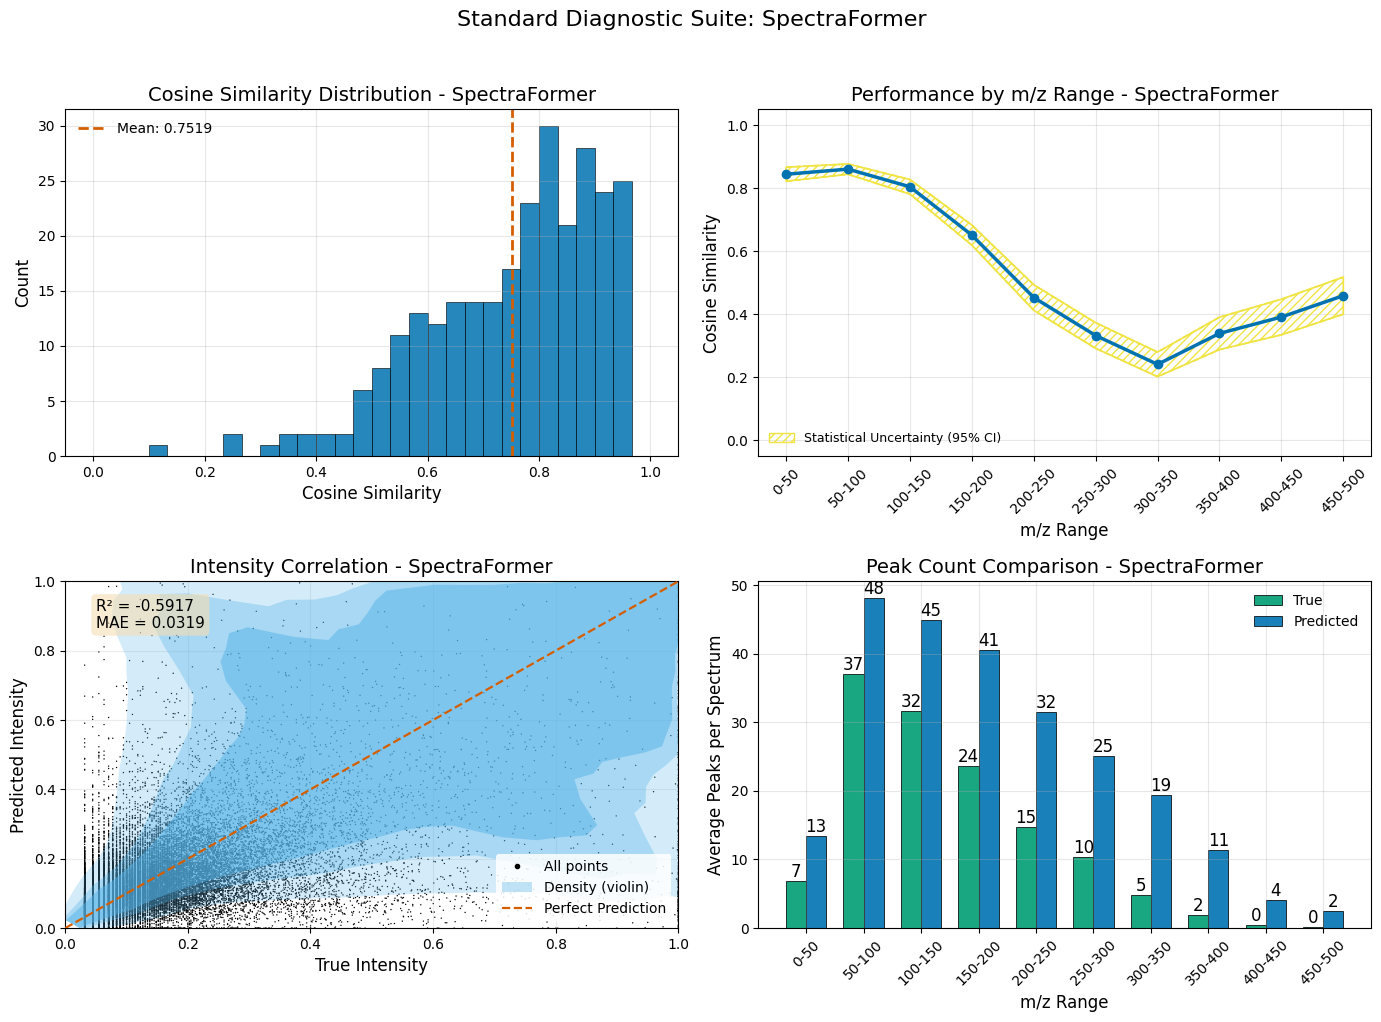


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 30: Cosine=0.7978, WDP=0.6614
  2. Index 116: Cosine=0.7180, WDP=0.4822
  3. Index 79: Cosine=0.9215, WDP=0.5675
  4. Index 127: Cosine=0.7746, WDP=0.3788


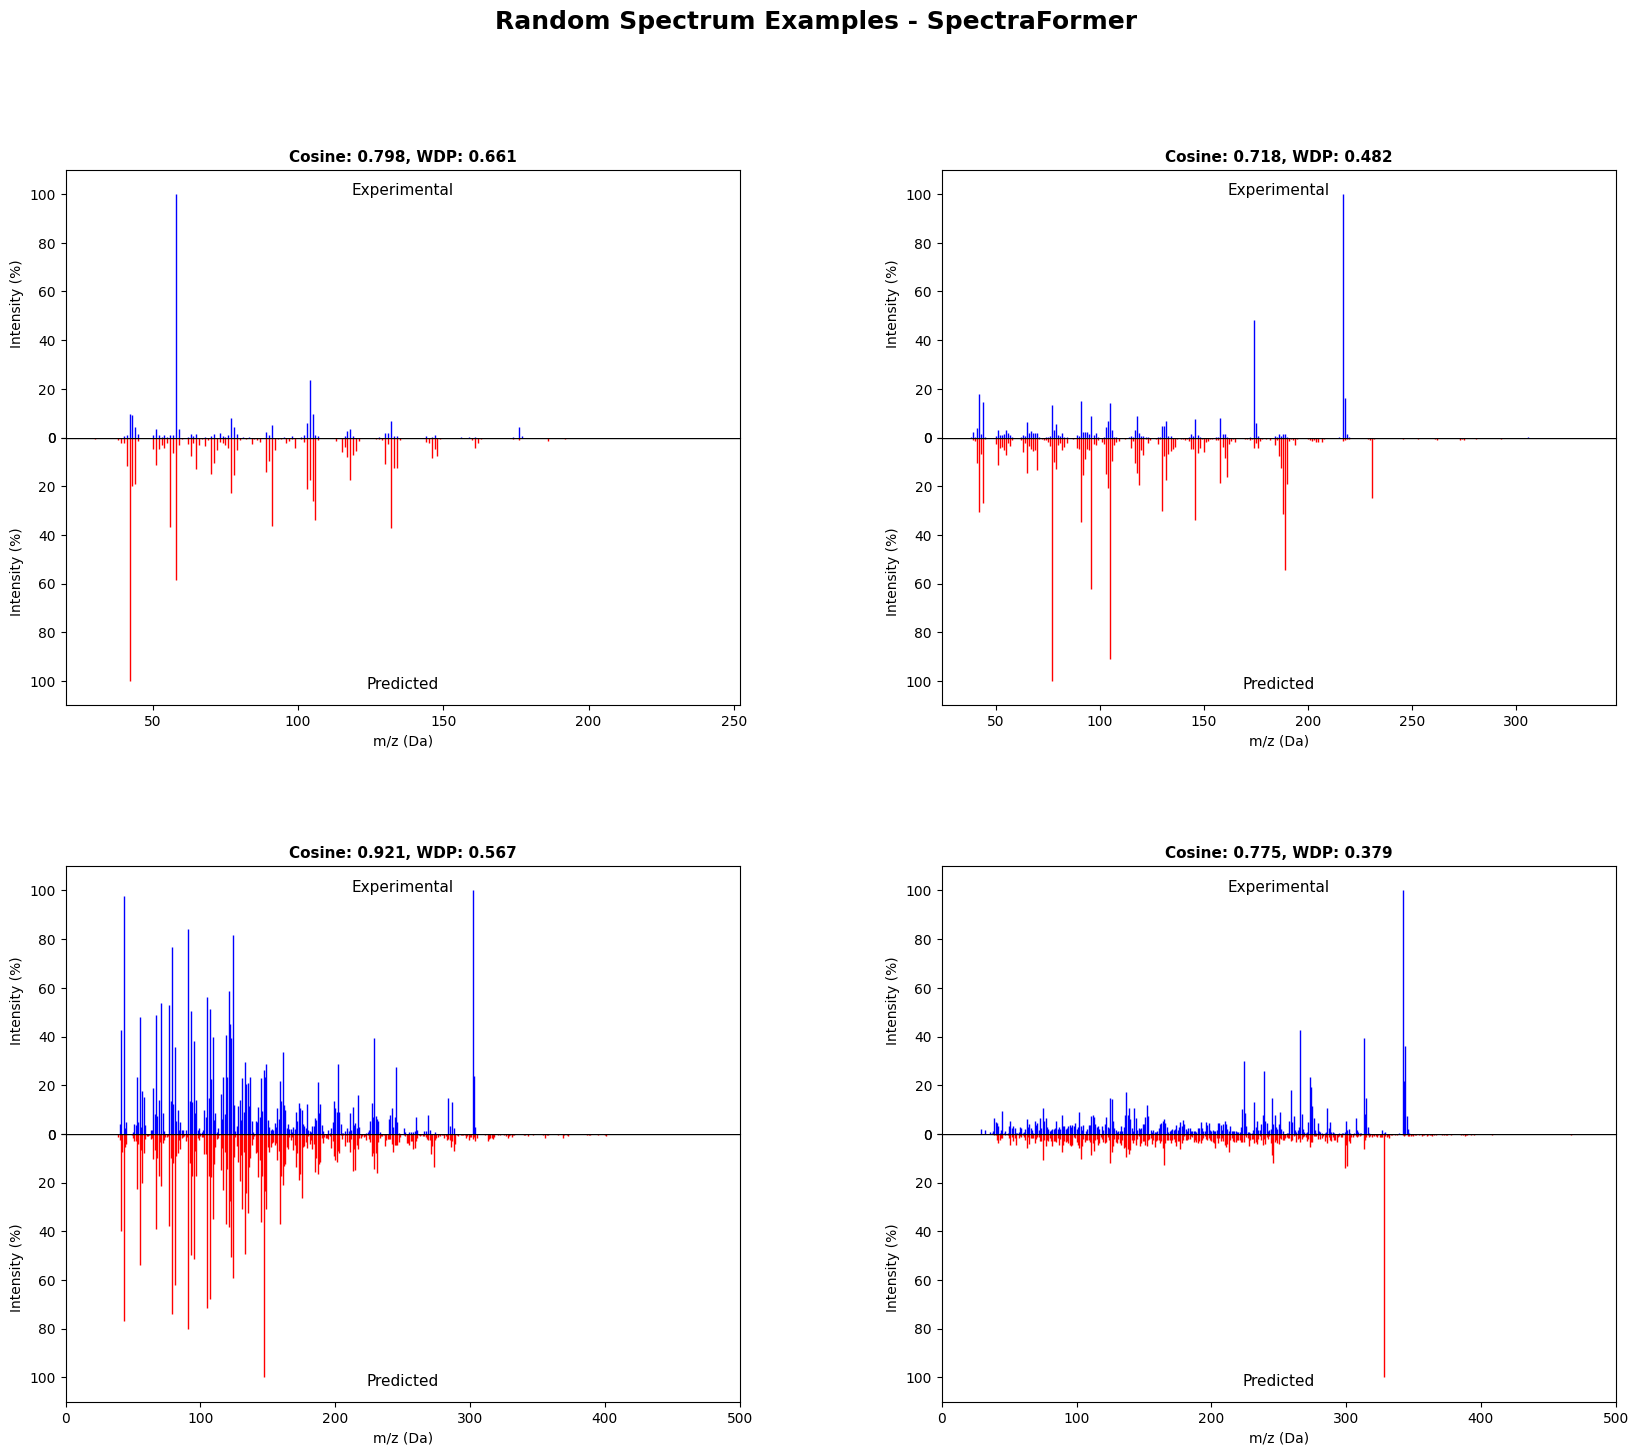


3. Deep Learning Training History


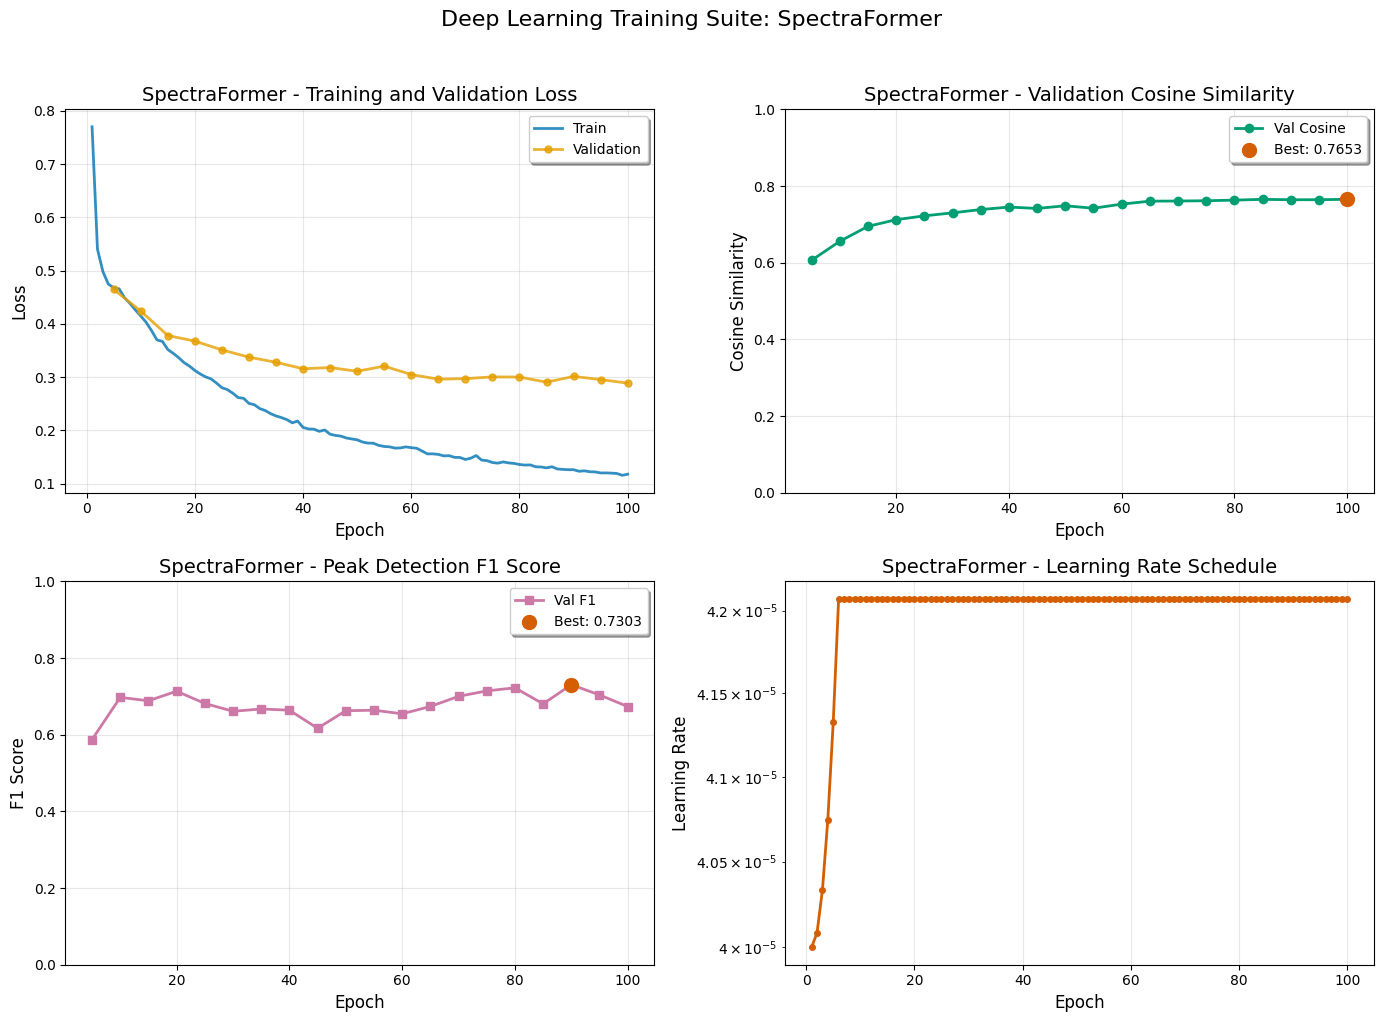


SpectraFormer evaluation complete!


In [38]:
class SpectraFormer(BaseModel):
    """Encoder-only transformer with Q→K/V cross-attention
    
    Learn L=500 query tokens (one per m/z bin) that attend to molecule context.
    """
    
    def __init__(self, input_dim: int, output_dim: int, cfg: Dict):
        super().__init__(input_dim, output_dim)
        
        d = cfg['d_model']
        h = cfg['heads']
        depth = cfg['depth']
        drop = cfg.get('drop', 0.1)
        context_tokens = cfg.get('context_tokens', 8)
        
        # Query embeddings for each m/z bin
        self.query_emb = nn.Parameter(torch.randn(output_dim, d))
        
        # Context tokens to expand molecule representation
        self.ctx_tokens = nn.Parameter(torch.randn(context_tokens, d))
        
        # Molecule encoder
        self.mol_proj = nn.Sequential(
            nn.Linear(input_dim, d),
            nn.ReLU(),
            nn.Linear(d, d)
        )
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d, h, drop) for _ in range(depth)
        ])
        
        # Output normalization and head
        self.norm = nn.LayerNorm(d)
        self.head = nn.Sequential(
            nn.Linear(d, d),
            nn.ReLU(),
            nn.Linear(d, 1)
        )
        
        # Positional encoding
        self.pos_enc = ALiBi(h, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        
        # Expand query embeddings for batch
        q = self.query_emb.unsqueeze(0).expand(B, -1, -1)  # (B, L, d)
        
        # Expand context tokens
        ctx = self.ctx_tokens.unsqueeze(0).expand(B, -1, -1)  # (B, C, d)
        
        # Encode molecule
        mol = self.mol_proj(x).unsqueeze(1)  # (B, 1, d)
        
        # FiLM conditioning: modulate queries with molecule features
        scale = torch.tanh(mol) + 1.0
        q = q * scale
        
        # Process through transformer blocks
        z = q
        for blk in self.blocks:
            z = blk(z)
        
        # Final normalization and output
        z = self.norm(z)
        y = self.head(z).squeeze(-1)  # (B, L)
        
        return F.relu(y)


# Train and evaluate SpectraFormer
if len(X_train) > 0:
    results_spectra = train_and_evaluate_model(SpectraFormer, 'SpectraFormer')

## 9. ViT-1D Architecture

Patches the spectrum into segments; processes with Transformer; decodes patches back to spectrum.

```mermaid
flowchart TD
  X["Molecule x"] --> Enc["MLP → d"]
  Enc --> CLS["CLS token + pos emb"]
  Q["Learned patch queries (L/p × p)"] --> PE["Linear p→d"]
  PE --> Tok["Patch tokens"]
  CLS --> Concat
  Tok --> Concat
  Concat --> Blocks["Transformer blocks"]
  Blocks --> Norm["LayerNorm"]
  Norm --> Head["Linear d→p"]
  Head --> Reshape["Reshape → L"]
  Reshape --> O["ŷ (L)"]
```


TRAINING VIT1D
Total parameters: 28,934,137

Training ViT1D...


Epoch 5/100: 100%|██████████| 68/68 [00:02<00:00, 27.89it/s, loss=0.7149, cos=0.5278]



ViT1D Performance:
  Cosine Similarity: 0.4937
  MSE: 0.0286, R²: -5.3700
  Peak Detection - Precision: 0.4043, Recall: 0.8398, F1: 0.5459
  Sparsity - True: 0.740, Pred: 0.464
  New best model saved! (Cosine: 0.4937)


Epoch 10/100: 100%|██████████| 68/68 [00:02<00:00, 30.10it/s, loss=0.5315, cos=0.4367]



ViT1D Performance:
  Cosine Similarity: 0.5561
  MSE: 0.0199, R²: -2.4252
  Peak Detection - Precision: 0.4377, Recall: 0.9685, F1: 0.6029
  Sparsity - True: 0.740, Pred: 0.434
  New best model saved! (Cosine: 0.5561)


Epoch 15/100: 100%|██████████| 68/68 [00:02<00:00, 30.15it/s, loss=0.6028, cos=0.4831]



ViT1D Performance:
  Cosine Similarity: 0.5521
  MSE: 0.0149, R²: -0.3232
  Peak Detection - Precision: 0.5533, Recall: 0.9255, F1: 0.6926
  Sparsity - True: 0.740, Pred: 0.573


Epoch 20/100: 100%|██████████| 68/68 [00:02<00:00, 26.02it/s, loss=0.5130, cos=0.4197]



ViT1D Performance:
  Cosine Similarity: 0.5779
  MSE: 0.0152, R²: -0.3371
  Peak Detection - Precision: 0.5202, Recall: 0.9495, F1: 0.6722
  Sparsity - True: 0.740, Pred: 0.534
  New best model saved! (Cosine: 0.5779)


Epoch 25/100: 100%|██████████| 68/68 [00:02<00:00, 27.26it/s, loss=0.4873, cos=0.3987]



ViT1D Performance:
  Cosine Similarity: 0.5926
  MSE: 0.0163, R²: -0.4657
  Peak Detection - Precision: 0.5131, Recall: 0.9478, F1: 0.6657
  Sparsity - True: 0.740, Pred: 0.527
  New best model saved! (Cosine: 0.5926)


Epoch 30/100: 100%|██████████| 68/68 [00:02<00:00, 27.12it/s, loss=0.4750, cos=0.3851]



ViT1D Performance:
  Cosine Similarity: 0.6068
  MSE: 0.0191, R²: -0.7401
  Peak Detection - Precision: 0.4687, Recall: 0.9725, F1: 0.6325
  Sparsity - True: 0.740, Pred: 0.467
  New best model saved! (Cosine: 0.6068)


Epoch 35/100: 100%|██████████| 68/68 [00:02<00:00, 26.90it/s, loss=0.4267, cos=0.3478]



ViT1D Performance:
  Cosine Similarity: 0.6146
  MSE: 0.0175, R²: -0.9147
  Peak Detection - Precision: 0.4415, Recall: 0.9794, F1: 0.6086
  Sparsity - True: 0.740, Pred: 0.431
  New best model saved! (Cosine: 0.6146)


Epoch 40/100: 100%|██████████| 68/68 [00:02<00:00, 26.50it/s, loss=0.4484, cos=0.3701]



ViT1D Performance:
  Cosine Similarity: 0.6288
  MSE: 0.0156, R²: -0.5289
  Peak Detection - Precision: 0.4829, Recall: 0.9685, F1: 0.6444
  Sparsity - True: 0.740, Pred: 0.486
  New best model saved! (Cosine: 0.6288)


Epoch 45/100: 100%|██████████| 68/68 [00:02<00:00, 26.65it/s, loss=0.4431, cos=0.3560]



ViT1D Performance:
  Cosine Similarity: 0.6486
  MSE: 0.0128, R²: -0.3251
  Peak Detection - Precision: 0.5147, Recall: 0.9615, F1: 0.6705
  Sparsity - True: 0.740, Pred: 0.522
  New best model saved! (Cosine: 0.6486)


Epoch 50/100: 100%|██████████| 68/68 [00:02<00:00, 25.87it/s, loss=0.3835, cos=0.3158]



ViT1D Performance:
  Cosine Similarity: 0.6500
  MSE: 0.0132, R²: -0.3117
  Peak Detection - Precision: 0.5120, Recall: 0.9640, F1: 0.6688
  Sparsity - True: 0.740, Pred: 0.518
  New best model saved! (Cosine: 0.6500)


Epoch 55/100: 100%|██████████| 68/68 [00:02<00:00, 25.90it/s, loss=0.4200, cos=0.3341]



ViT1D Performance:
  Cosine Similarity: 0.6631
  MSE: 0.0120, R²: -0.1265
  Peak Detection - Precision: 0.5328, Recall: 0.9533, F1: 0.6836
  Sparsity - True: 0.740, Pred: 0.542
  New best model saved! (Cosine: 0.6631)


Epoch 60/100: 100%|██████████| 68/68 [00:02<00:00, 25.16it/s, loss=0.3669, cos=0.2870]



ViT1D Performance:
  Cosine Similarity: 0.6738
  MSE: 0.0110, R²: -0.0714
  Peak Detection - Precision: 0.5487, Recall: 0.9477, F1: 0.6950
  Sparsity - True: 0.740, Pred: 0.558
  New best model saved! (Cosine: 0.6738)


Epoch 65/100: 100%|██████████| 68/68 [00:02<00:00, 25.29it/s, loss=0.3608, cos=0.2761]



ViT1D Performance:
  Cosine Similarity: 0.6874
  MSE: 0.0105, R²: -0.0208
  Peak Detection - Precision: 0.5645, Recall: 0.9403, F1: 0.7055
  Sparsity - True: 0.740, Pred: 0.574
  New best model saved! (Cosine: 0.6874)


Epoch 70/100: 100%|██████████| 68/68 [00:02<00:00, 26.49it/s, loss=0.3626, cos=0.2798]



ViT1D Performance:
  Cosine Similarity: 0.6809
  MSE: 0.0117, R²: -0.1181
  Peak Detection - Precision: 0.5382, Recall: 0.9375, F1: 0.6838
  Sparsity - True: 0.740, Pred: 0.552


Epoch 75/100: 100%|██████████| 68/68 [00:02<00:00, 26.78it/s, loss=0.3077, cos=0.2409]



ViT1D Performance:
  Cosine Similarity: 0.7004
  MSE: 0.0109, R²: -0.0719
  Peak Detection - Precision: 0.5543, Recall: 0.9468, F1: 0.6993
  Sparsity - True: 0.740, Pred: 0.560
  New best model saved! (Cosine: 0.7004)


Epoch 80/100: 100%|██████████| 68/68 [00:02<00:00, 25.26it/s, loss=0.3327, cos=0.2580]



ViT1D Performance:
  Cosine Similarity: 0.7005
  MSE: 0.0109, R²: -0.0321
  Peak Detection - Precision: 0.5306, Recall: 0.9537, F1: 0.6818
  Sparsity - True: 0.740, Pred: 0.536
  New best model saved! (Cosine: 0.7005)


Epoch 85/100: 100%|██████████| 68/68 [00:02<00:00, 26.25it/s, loss=0.2948, cos=0.2289]



ViT1D Performance:
  Cosine Similarity: 0.7006
  MSE: 0.0102, R²: 0.0015
  Peak Detection - Precision: 0.5702, Recall: 0.9274, F1: 0.7062
  Sparsity - True: 0.740, Pred: 0.580
  New best model saved! (Cosine: 0.7006)


Epoch 90/100: 100%|██████████| 68/68 [00:02<00:00, 28.33it/s, loss=0.3253, cos=0.2538]



ViT1D Performance:
  Cosine Similarity: 0.6968
  MSE: 0.0104, R²: -0.0076
  Peak Detection - Precision: 0.5805, Recall: 0.9226, F1: 0.7126
  Sparsity - True: 0.740, Pred: 0.589


Epoch 95/100: 100%|██████████| 68/68 [00:02<00:00, 24.86it/s, loss=0.3097, cos=0.2220]



ViT1D Performance:
  Cosine Similarity: 0.7082
  MSE: 0.0089, R²: 0.1339
  Peak Detection - Precision: 0.6448, Recall: 0.8769, F1: 0.7431
  Sparsity - True: 0.740, Pred: 0.649
  New best model saved! (Cosine: 0.7082)


Epoch 100/100: 100%|██████████| 68/68 [00:02<00:00, 27.91it/s, loss=0.2871, cos=0.2185]



ViT1D Performance:
  Cosine Similarity: 0.7207
  MSE: 0.0095, R²: 0.0761
  Peak Detection - Precision: 0.6164, Recall: 0.9091, F1: 0.7347
  Sparsity - True: 0.740, Pred: 0.617
  New best model saved! (Cosine: 0.7207)

Training complete. Best validation cosine: 0.7207

ViT1D Performance:
  Cosine Similarity: 0.7217
  MSE: 0.0076, R²: -0.0417
  Peak Detection - Precision: 0.6269, Recall: 0.9158, F1: 0.7443
  Sparsity - True: 0.736, Pred: 0.618

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


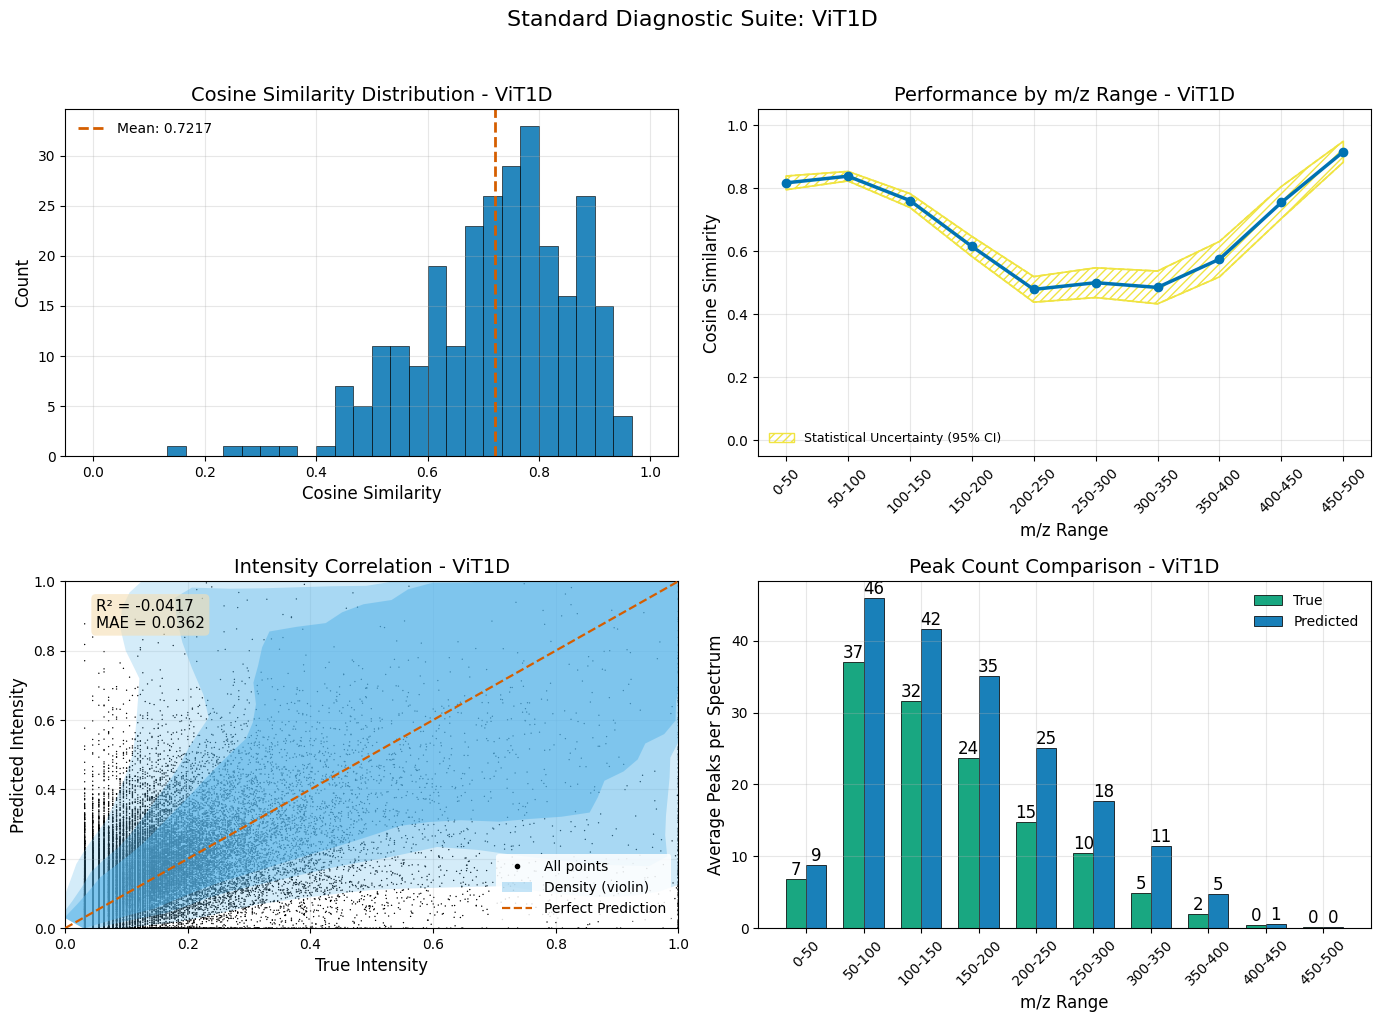


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 83: Cosine=0.8006, WDP=0.3918
  2. Index 81: Cosine=0.3317, WDP=0.1974
  3. Index 265: Cosine=0.5946, WDP=0.4288
  4. Index 128: Cosine=0.6870, WDP=0.7209


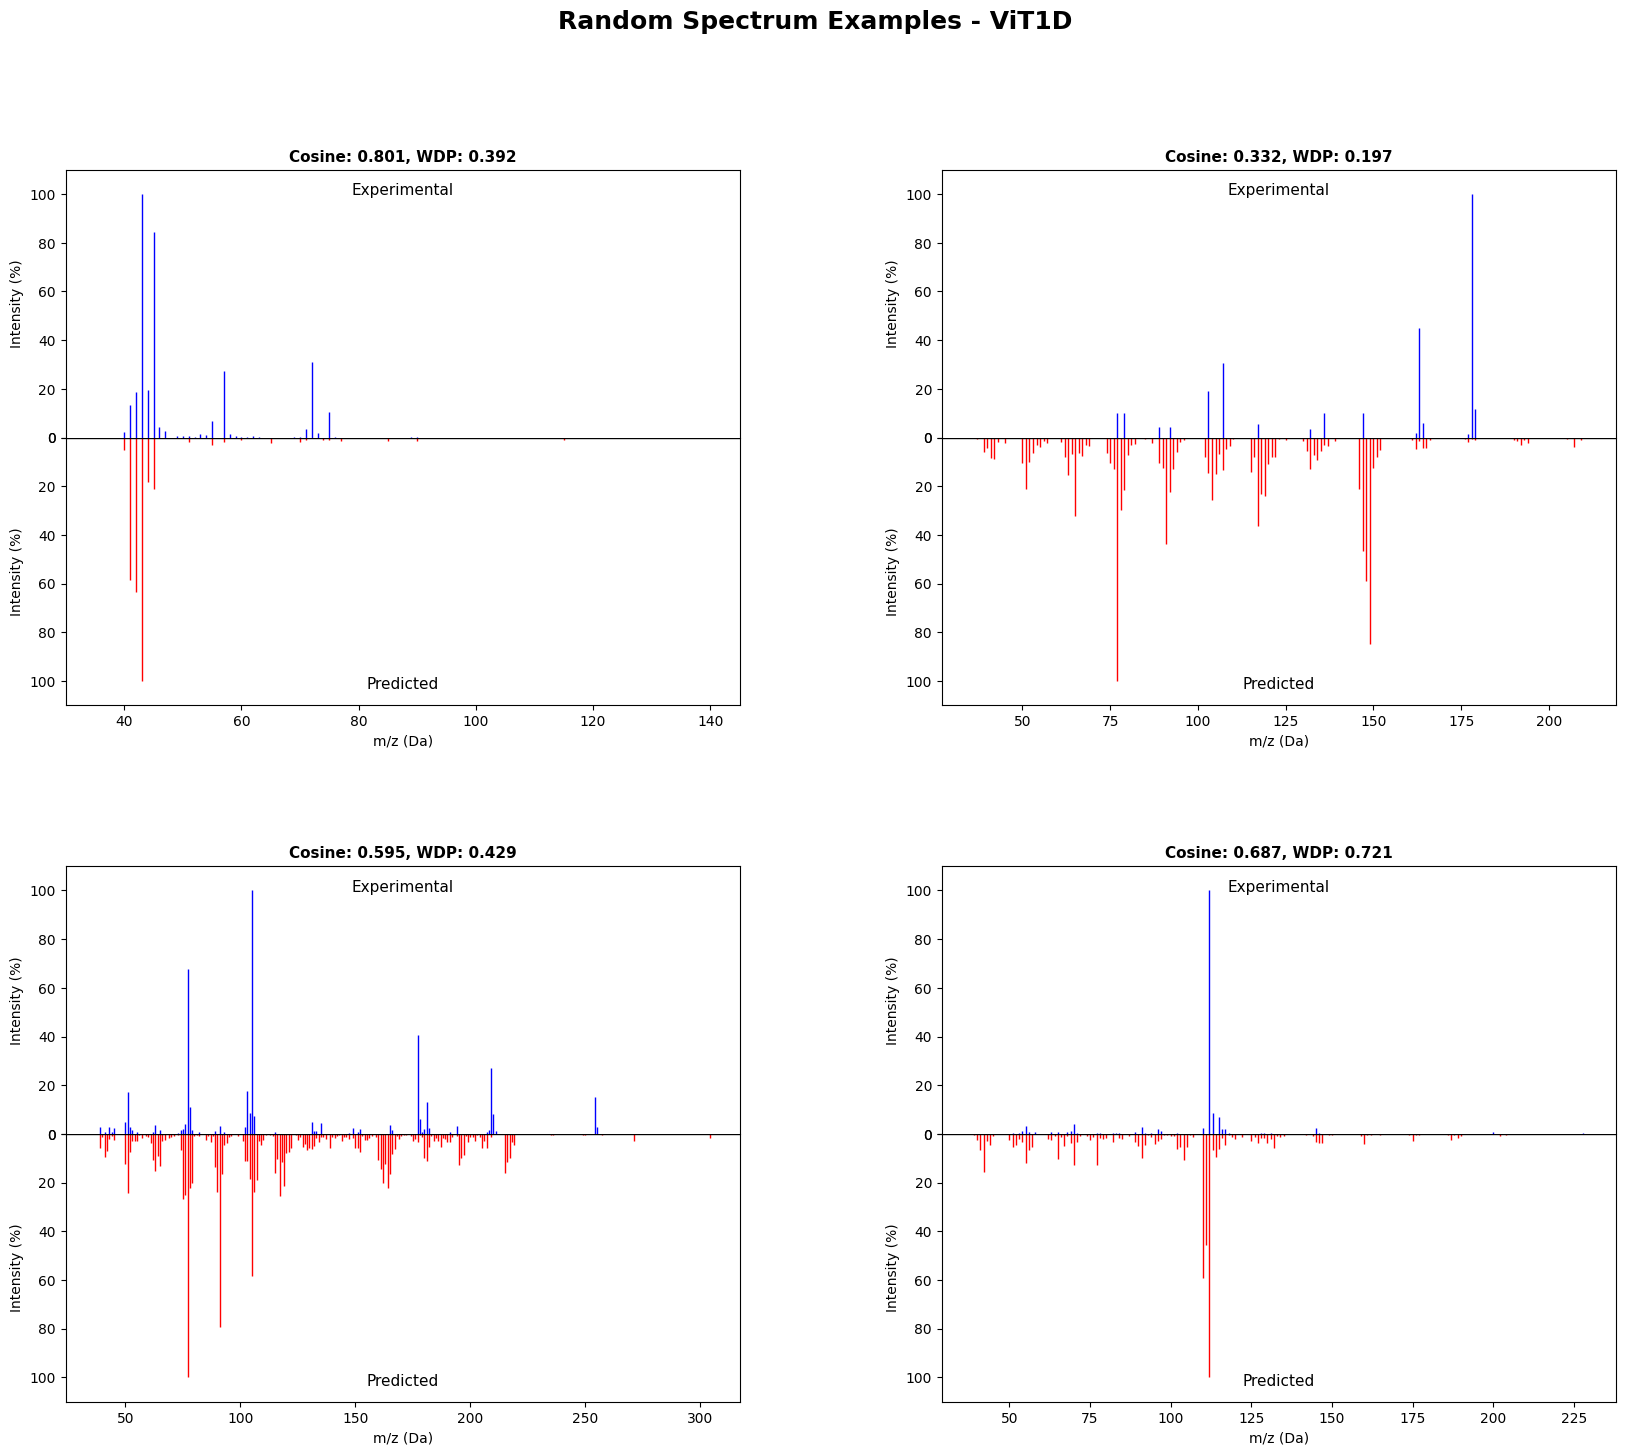


3. Deep Learning Training History


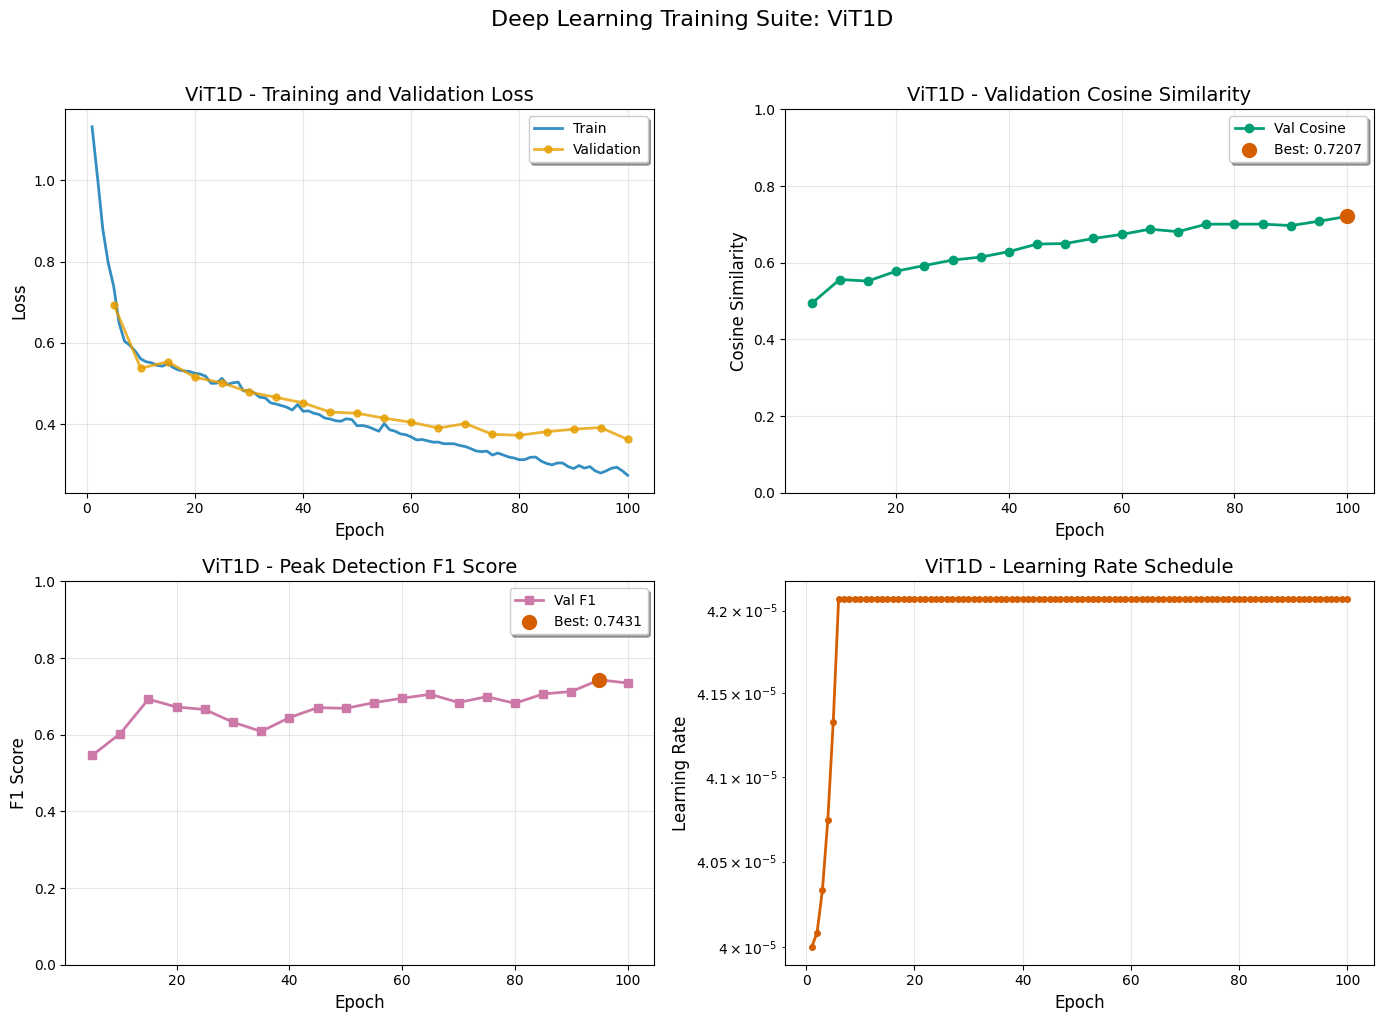


ViT1D evaluation complete!


In [39]:
class ViT1D(BaseModel):
    """1D Vision Transformer treating spectrum as 1D image
    
    Patches spectrum into p-sized segments and processes with transformer.
    """
    
    def __init__(self, input_dim: int, output_dim: int, cfg: Dict):
        super().__init__(input_dim, output_dim)
        
        d = cfg['d_model']
        h = cfg['heads']
        depth = cfg['depth']
        patch_size = cfg.get('patch_size', 5)
        drop = cfg.get('drop', 0.1)
        
        self.patch_size = patch_size
        self.num_patches = output_dim // patch_size
        
        # Learnable patch queries
        self.patch_queries = nn.Parameter(
            torch.randn(self.num_patches, self.patch_size)
        )
        
        # Molecule encoder
        self.mol_encoder = nn.Sequential(
            nn.Linear(input_dim, d),
            nn.LayerNorm(d),
            nn.ReLU(),
            nn.Dropout(drop)
        )
        
        # CLS token for molecule representation
        self.cls_token = nn.Parameter(torch.randn(1, 1, d))
        
        # Patch embedding
        self.patch_embed = nn.Linear(patch_size, d)
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, d))
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d, h, drop) for _ in range(depth)
        ])
        
        # Output head
        self.norm = nn.LayerNorm(d)
        self.head = nn.Linear(d, patch_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        
        # Encode molecule as CLS token
        mol_feat = self.mol_encoder(x).unsqueeze(1)  # (B, 1, d)
        cls = self.cls_token.expand(B, -1, -1) + mol_feat  # (B, 1, d)
        
        # Use learned patch queries
        patch_queries = self.patch_queries.unsqueeze(0).expand(B, -1, -1)  # (B, num_patches, patch_size)
        patches = self.patch_embed(patch_queries)  # (B, num_patches, d)
        
        # Concatenate CLS and patches
        tokens = torch.cat([cls, patches], dim=1)  # (B, num_patches+1, d)
        
        # Add positional embeddings
        tokens = tokens + self.pos_embed
        
        # Process through transformer
        for blk in self.blocks:
            tokens = blk(tokens)
        
        # Extract patch tokens (skip CLS)
        patches_out = tokens[:, 1:, :]  # (B, num_patches, d)
        patches_out = self.norm(patches_out)
        
        # Decode to spectrum
        spectrum_patches = self.head(patches_out)  # (B, num_patches, patch_size)
        spectrum = spectrum_patches.reshape(B, -1)  # (B, L)
        
        # Handle dimension mismatch if needed
        if spectrum.size(1) < self.output_dim:
            padding = self.output_dim - spectrum.size(1)
            spectrum = F.pad(spectrum, (0, padding))
        elif spectrum.size(1) > self.output_dim:
            spectrum = spectrum[:, :self.output_dim]
        
        return F.relu(spectrum)


# Train and evaluate ViT-1D
if len(X_train) > 0:
    results_vit = train_and_evaluate_model(ViT1D, 'ViT1D')

## 10. LinearAttention-1D Architecture

FAVOR-style linear attention with positive feature maps and stabilized kernels.

```mermaid
flowchart TD
  X["Tokens (B×L×d)"] --> Proj["W_q, W_k, W_v"]
  Proj --> Phi["φ(Q), φ(K) (ELU+1) → normalize"]
  Phi --> KV["KV = Σ_l φ(K_l)^T V_l"]
  Phi --> Z["Z = φ(Q) Σ_l φ(K_l)"]
  KV --> Num["Numerator = φ(Q) KV"]
  Z --> Div
  Num --> Div["Divide by Z"]
  Div --> Merge["Merge heads → W_o"]
  Merge --> O["ŷ tokens"]
```


TRAINING LINEARATTN1D
Total parameters: 14,774,721

Training LinearAttn1D...


Epoch 5/100: 100%|██████████| 68/68 [00:07<00:00,  9.49it/s, loss=0.7577, cos=0.6532]



LinearAttn1D Performance:
  Cosine Similarity: 0.3597
  MSE: 0.0322, R²: -65.0798
  Peak Detection - Precision: 0.2599, Recall: 1.0000, F1: 0.4126
  Sparsity - True: 0.740, Pred: 0.032
  New best model saved! (Cosine: 0.3597)


Epoch 10/100: 100%|██████████| 68/68 [00:06<00:00,  9.86it/s, loss=0.5764, cos=0.4991]



LinearAttn1D Performance:
  Cosine Similarity: 0.5259
  MSE: 0.0227, R²: -13.0906
  Peak Detection - Precision: 0.2600, Recall: 1.0000, F1: 0.4127
  Sparsity - True: 0.740, Pred: 0.057
  New best model saved! (Cosine: 0.5259)


Epoch 15/100: 100%|██████████| 68/68 [00:06<00:00, 10.85it/s, loss=0.5715, cos=0.4932]



LinearAttn1D Performance:
  Cosine Similarity: 0.5576
  MSE: 0.0123, R²: -2.9530
  Peak Detection - Precision: 0.3056, Recall: 0.9973, F1: 0.4678
  Sparsity - True: 0.740, Pred: 0.269
  New best model saved! (Cosine: 0.5576)


Epoch 20/100: 100%|██████████| 68/68 [00:07<00:00,  9.60it/s, loss=0.5118, cos=0.4438]



LinearAttn1D Performance:
  Cosine Similarity: 0.5646
  MSE: 0.0116, R²: -1.1532
  Peak Detection - Precision: 0.3301, Recall: 0.9935, F1: 0.4955
  Sparsity - True: 0.740, Pred: 0.344
  New best model saved! (Cosine: 0.5646)


Epoch 25/100: 100%|██████████| 68/68 [00:07<00:00,  9.69it/s, loss=0.4630, cos=0.4026]



LinearAttn1D Performance:
  Cosine Similarity: 0.5687
  MSE: 0.0105, R²: -0.7394
  Peak Detection - Precision: 0.3418, Recall: 0.9928, F1: 0.5086
  Sparsity - True: 0.740, Pred: 0.394
  New best model saved! (Cosine: 0.5687)


Epoch 30/100: 100%|██████████| 68/68 [00:07<00:00,  9.53it/s, loss=0.4926, cos=0.4288]



LinearAttn1D Performance:
  Cosine Similarity: 0.5768
  MSE: 0.0098, R²: -0.2286
  Peak Detection - Precision: 0.3746, Recall: 0.9877, F1: 0.5431
  Sparsity - True: 0.740, Pred: 0.486
  New best model saved! (Cosine: 0.5768)


Epoch 35/100: 100%|██████████| 68/68 [00:06<00:00, 10.05it/s, loss=0.5209, cos=0.4481]



LinearAttn1D Performance:
  Cosine Similarity: 0.5912
  MSE: 0.0098, R²: -0.1652
  Peak Detection - Precision: 0.3775, Recall: 0.9893, F1: 0.5465
  Sparsity - True: 0.740, Pred: 0.486
  New best model saved! (Cosine: 0.5912)


Epoch 40/100: 100%|██████████| 68/68 [00:06<00:00, 10.52it/s, loss=0.4586, cos=0.3972]



LinearAttn1D Performance:
  Cosine Similarity: 0.6086
  MSE: 0.0100, R²: -0.0778
  Peak Detection - Precision: 0.4006, Recall: 0.9812, F1: 0.5689
  Sparsity - True: 0.740, Pred: 0.518
  New best model saved! (Cosine: 0.6086)


Epoch 45/100: 100%|██████████| 68/68 [00:05<00:00, 11.63it/s, loss=0.3980, cos=0.3431]



LinearAttn1D Performance:
  Cosine Similarity: 0.6246
  MSE: 0.0113, R²: -0.2876
  Peak Detection - Precision: 0.4076, Recall: 0.9791, F1: 0.5756
  Sparsity - True: 0.740, Pred: 0.507
  New best model saved! (Cosine: 0.6246)


Epoch 50/100: 100%|██████████| 68/68 [00:07<00:00,  9.48it/s, loss=0.3772, cos=0.3240]



LinearAttn1D Performance:
  Cosine Similarity: 0.6414
  MSE: 0.0105, R²: -0.3191
  Peak Detection - Precision: 0.4190, Recall: 0.9743, F1: 0.5860
  Sparsity - True: 0.740, Pred: 0.523
  New best model saved! (Cosine: 0.6414)


Epoch 55/100: 100%|██████████| 68/68 [00:06<00:00, 10.27it/s, loss=0.3991, cos=0.3439]



LinearAttn1D Performance:
  Cosine Similarity: 0.6528
  MSE: 0.0097, R²: -0.0668
  Peak Detection - Precision: 0.4302, Recall: 0.9728, F1: 0.5966
  Sparsity - True: 0.740, Pred: 0.553
  New best model saved! (Cosine: 0.6528)


Epoch 60/100: 100%|██████████| 68/68 [00:06<00:00,  9.99it/s, loss=0.3537, cos=0.3043]



LinearAttn1D Performance:
  Cosine Similarity: 0.6645
  MSE: 0.0098, R²: -0.0935
  Peak Detection - Precision: 0.4269, Recall: 0.9746, F1: 0.5938
  Sparsity - True: 0.740, Pred: 0.526
  New best model saved! (Cosine: 0.6645)


Epoch 65/100: 100%|██████████| 68/68 [00:10<00:00,  6.20it/s, loss=0.3913, cos=0.3334]



LinearAttn1D Performance:
  Cosine Similarity: 0.6740
  MSE: 0.0096, R²: -0.0406
  Peak Detection - Precision: 0.4574, Recall: 0.9693, F1: 0.6215
  Sparsity - True: 0.740, Pred: 0.565
  New best model saved! (Cosine: 0.6740)


Epoch 70/100: 100%|██████████| 68/68 [00:14<00:00,  4.68it/s, loss=0.2887, cos=0.2442]



LinearAttn1D Performance:
  Cosine Similarity: 0.6839
  MSE: 0.0119, R²: -0.2243
  Peak Detection - Precision: 0.4586, Recall: 0.9695, F1: 0.6226
  Sparsity - True: 0.740, Pred: 0.563
  New best model saved! (Cosine: 0.6839)


Epoch 75/100: 100%|██████████| 68/68 [00:17<00:00,  3.88it/s, loss=0.3077, cos=0.2629]



LinearAttn1D Performance:
  Cosine Similarity: 0.6932
  MSE: 0.0114, R²: -0.1685
  Peak Detection - Precision: 0.4854, Recall: 0.9564, F1: 0.6440
  Sparsity - True: 0.740, Pred: 0.589
  New best model saved! (Cosine: 0.6932)


Epoch 80/100: 100%|██████████| 68/68 [00:08<00:00,  7.65it/s, loss=0.3216, cos=0.2740]



LinearAttn1D Performance:
  Cosine Similarity: 0.7053
  MSE: 0.0098, R²: -0.0407
  Peak Detection - Precision: 0.4863, Recall: 0.9580, F1: 0.6451
  Sparsity - True: 0.740, Pred: 0.621
  New best model saved! (Cosine: 0.7053)


Epoch 85/100: 100%|██████████| 68/68 [00:15<00:00,  4.38it/s, loss=0.2863, cos=0.2408]



LinearAttn1D Performance:
  Cosine Similarity: 0.7070
  MSE: 0.0096, R²: -0.0185
  Peak Detection - Precision: 0.5022, Recall: 0.9493, F1: 0.6569
  Sparsity - True: 0.740, Pred: 0.627
  New best model saved! (Cosine: 0.7070)


Epoch 90/100: 100%|██████████| 68/68 [00:14<00:00,  4.83it/s, loss=0.2655, cos=0.2192]



LinearAttn1D Performance:
  Cosine Similarity: 0.7129
  MSE: 0.0123, R²: -0.2863
  Peak Detection - Precision: 0.4826, Recall: 0.9589, F1: 0.6420
  Sparsity - True: 0.740, Pred: 0.580
  New best model saved! (Cosine: 0.7129)


Epoch 95/100: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s, loss=0.2696, cos=0.2243]



LinearAttn1D Performance:
  Cosine Similarity: 0.7142
  MSE: 0.0111, R²: -0.1197
  Peak Detection - Precision: 0.5173, Recall: 0.9414, F1: 0.6677
  Sparsity - True: 0.740, Pred: 0.627
  New best model saved! (Cosine: 0.7142)


Epoch 100/100: 100%|██████████| 68/68 [00:09<00:00,  7.01it/s, loss=0.2667, cos=0.2210]



LinearAttn1D Performance:
  Cosine Similarity: 0.7195
  MSE: 0.0104, R²: -0.0607
  Peak Detection - Precision: 0.5157, Recall: 0.9455, F1: 0.6674
  Sparsity - True: 0.740, Pred: 0.622
  New best model saved! (Cosine: 0.7195)

Training complete. Best validation cosine: 0.7195

LinearAttn1D Performance:
  Cosine Similarity: 0.7181
  MSE: 0.0087, R²: -0.3913
  Peak Detection - Precision: 0.5179, Recall: 0.9469, F1: 0.6696
  Sparsity - True: 0.736, Pred: 0.618

------------------------------------------------------------
GENERATING STANDARD VISUALIZATIONS
------------------------------------------------------------

1. Standard 2x2 Diagnostic Plots


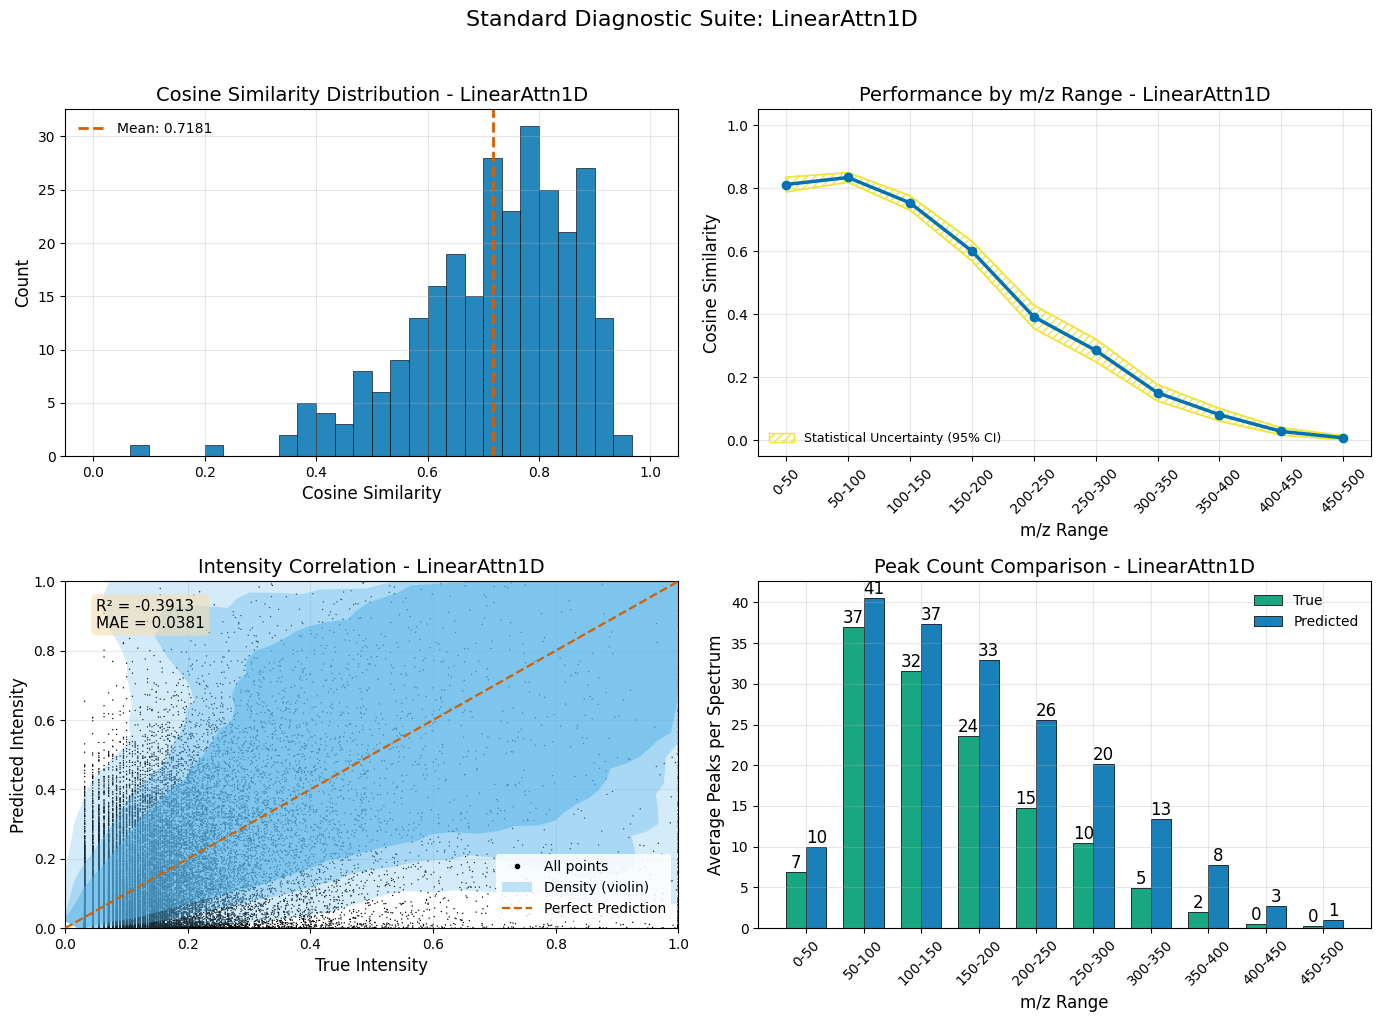


2. Random Spectrum Examples (2x2 Grid)

Selected random examples:
  1. Index 80: Cosine=0.7297, WDP=0.0650
  2. Index 129: Cosine=0.8485, WDP=0.3477
  3. Index 208: Cosine=0.7709, WDP=0.4032
  4. Index 241: Cosine=0.6052, WDP=0.3606


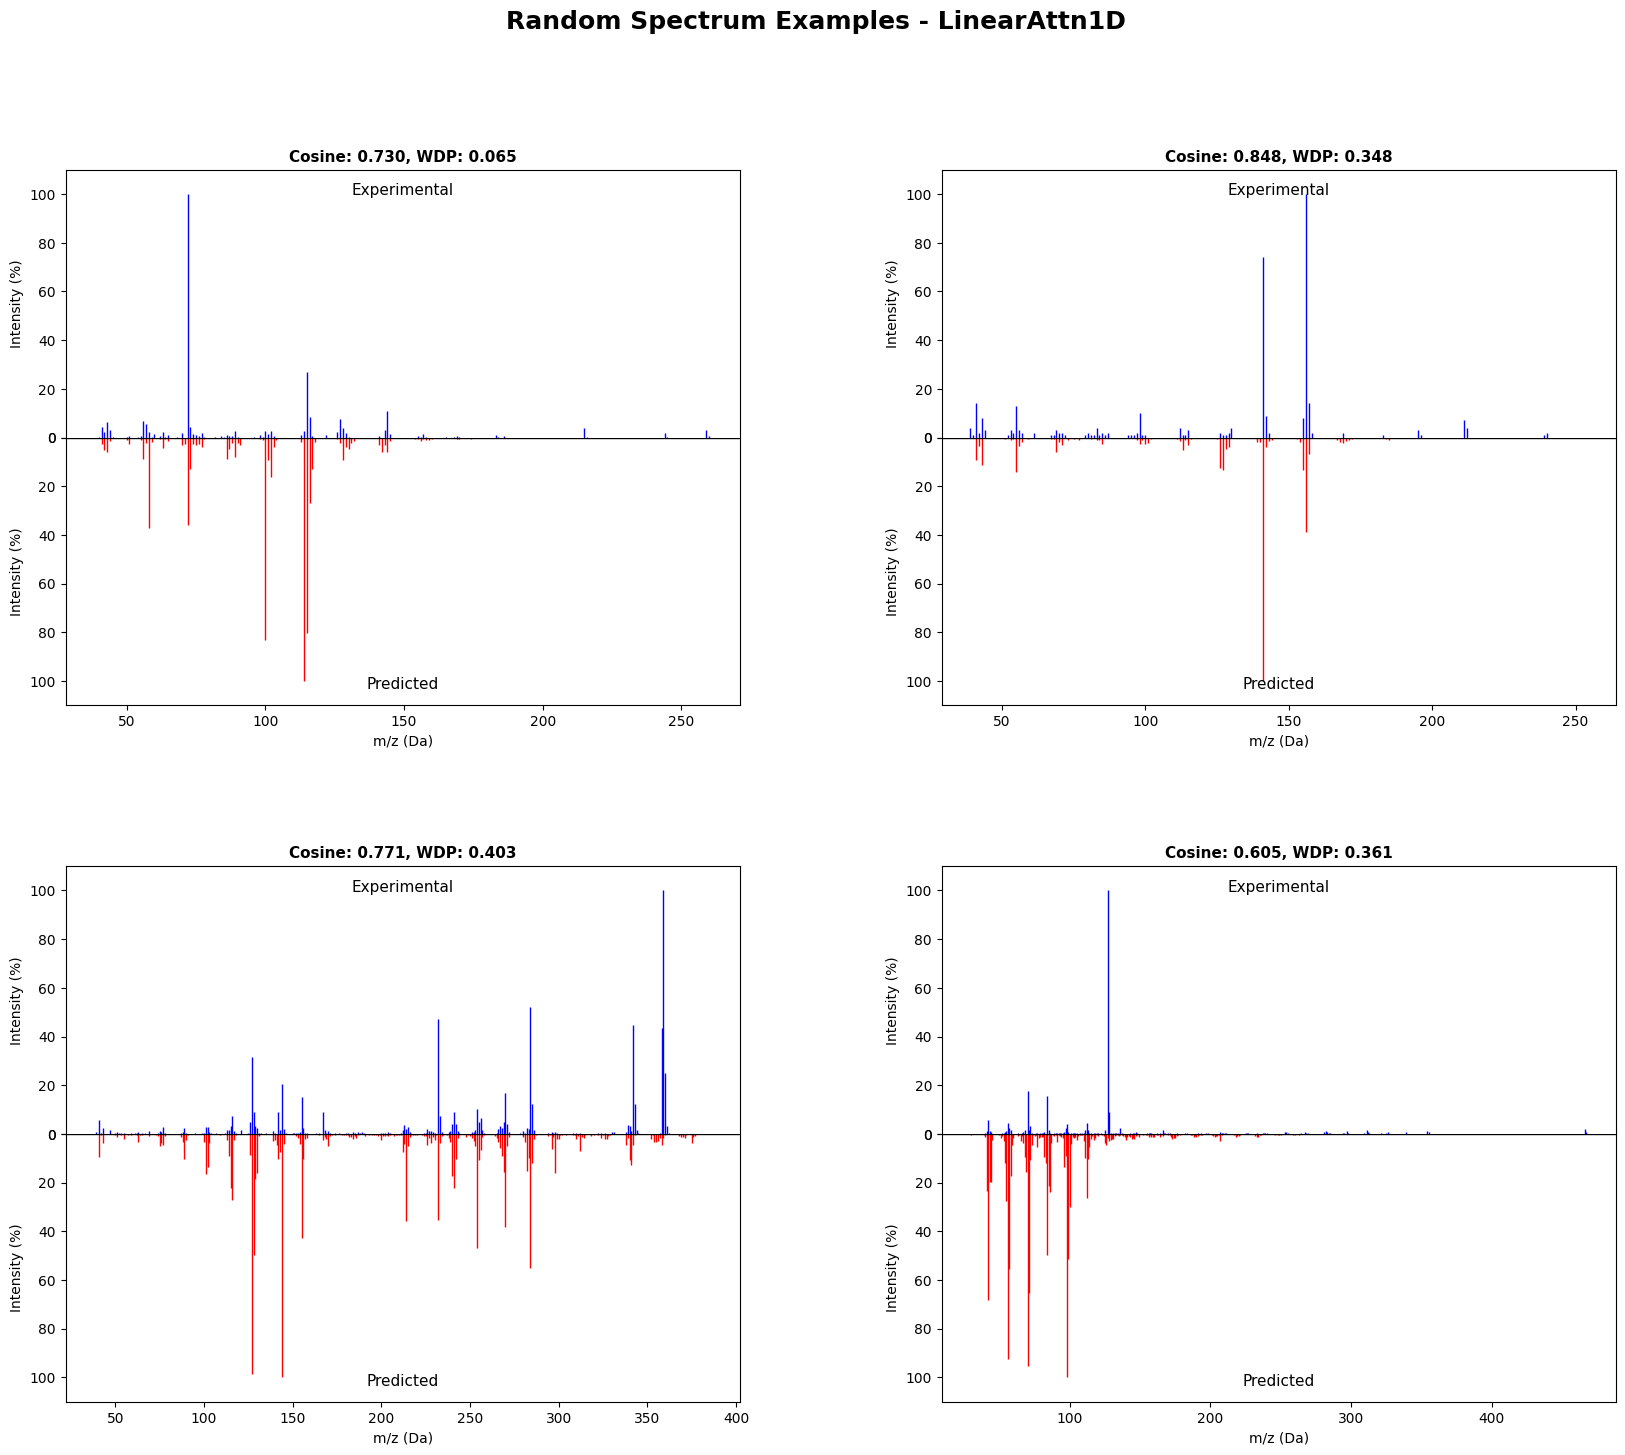


3. Deep Learning Training History


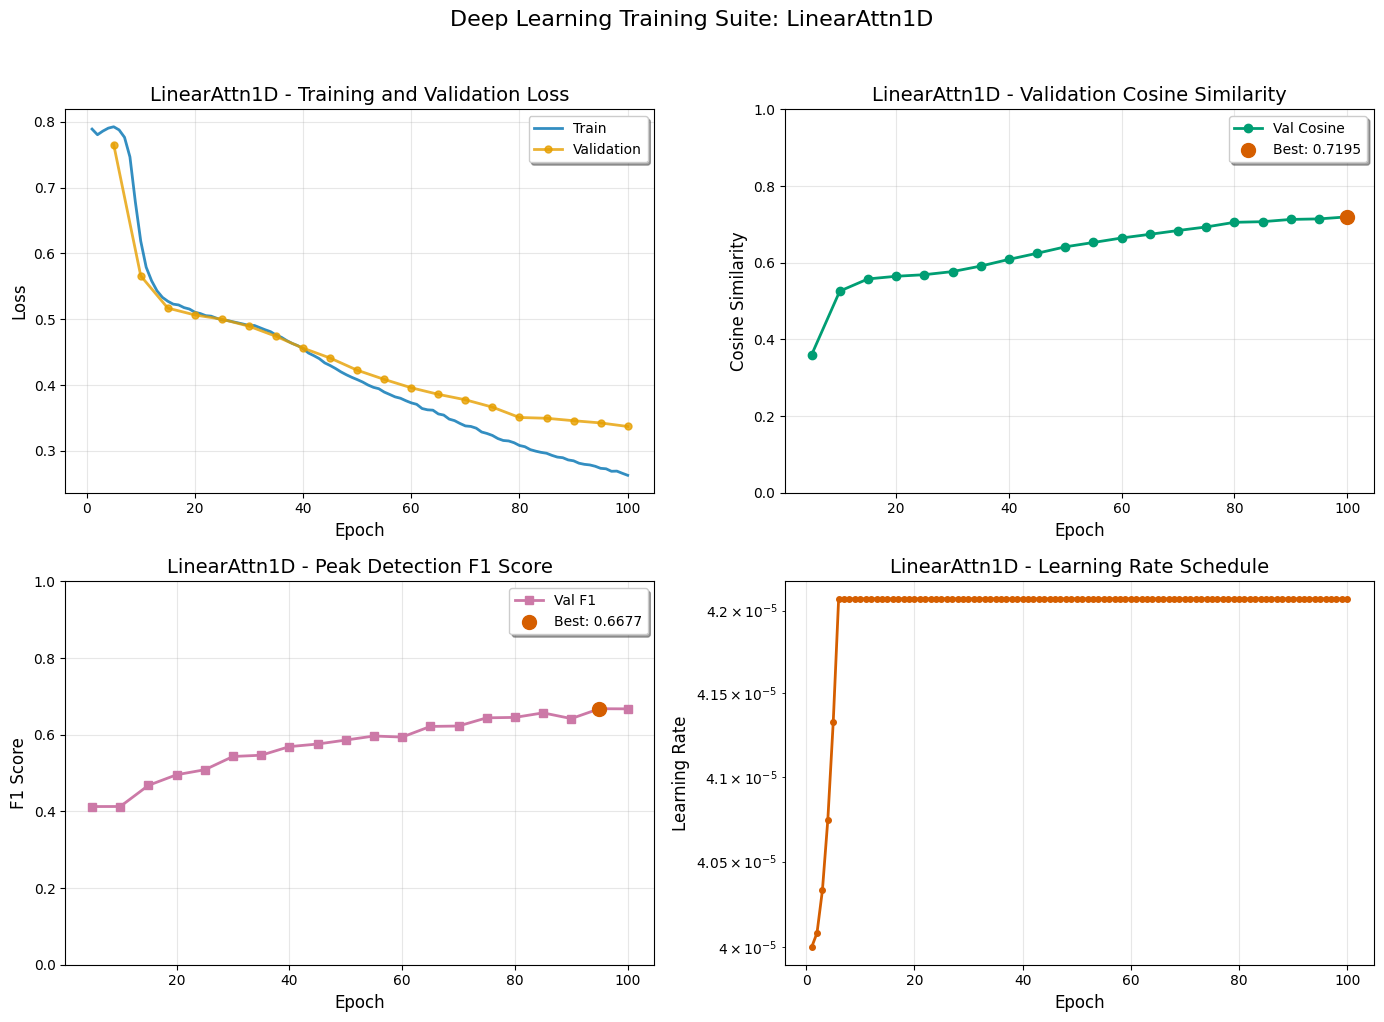


LinearAttn1D evaluation complete!


In [40]:
class LinearAttention(nn.Module):
    """Linear attention (FAVOR-style) with stability fixes:
       - compute in float32 to avoid fp16 overflow under autocast
       - positive feature map (ELU+1)
       - pre-scaling by 1/sqrt(d_k)
       - denominator clamp
       - light renormalization of phi(Q)/phi(K)
    """
    def __init__(self, d_model: int, n_heads: int, feature_map: str = 'elu'):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.scale = 1.0 / math.sqrt(self.d_k)
        self.register_buffer("eps", torch.tensor(1e-6))

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        if feature_map == 'elu':
            self.feature_map = lambda x: F.elu(x) + 1.0  # strictly positive
        else:
            # fallback still positive
            self.feature_map = lambda x: F.elu(x) + 1.0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Always do the kernelized attention in float32 for stability, even under autocast
        dtype_in = x.dtype
        B, L, _ = x.shape
        x32 = x.float()

        # Projections -> (B, L, H, d_k)
        Q = self.W_q(x32).view(B, L, self.n_heads, self.d_k) * self.scale
        K = self.W_k(x32).view(B, L, self.n_heads, self.d_k) * self.scale
        V = self.W_v(x32).view(B, L, self.n_heads, self.d_k)

        # Positive feature map
        Q = self.feature_map(Q)
        K = self.feature_map(K)

        # Light renormalization across feature dim to keep magnitudes tame
        Q = Q / (Q.sum(dim=-1, keepdim=True) + self.eps)
        K = K / (K.sum(dim=-1, keepdim=True) + self.eps)

        # Precompute KV = sum_l φ(K_l)^T V_l  -> (B, H, d_k, d_k)
        KV = torch.einsum('blhd,blhe->bhde', K, V)

        # Normalizer Z = φ(Q) (sum_l φ(K_l))  -> (B, L, H)
        K_sum = K.sum(dim=1)                                # (B, H, d_k)
        denom = torch.einsum('blhd,bhd->blh', Q, K_sum)     # (B, L, H)
        denom = denom.clamp_min(self.eps)                   # avoid divide-by-zero

        # Output = [φ(Q) (φ(K)^T V)] / Z  -> (B, L, H, d_k)
        numer = torch.einsum('blhd,bhde->blhe', Q, KV)
        out = numer / denom.unsqueeze(-1)

        # Merge heads, project out
        out = out.contiguous().view(B, L, self.d_model)
        out = self.W_o(out)

        # Cast back to input dtype
        return out.to(dtype_in)


class LinearAttn1D(BaseModel):
    """Transformer with linear attention for efficiency and stability."""
    def __init__(self, input_dim: int, output_dim: int, cfg: Dict):
        super().__init__(input_dim, output_dim)

        d = cfg['d_model']
        h = cfg['heads']
        depth = cfg['depth']
        feature_map = cfg.get('feature_map', 'elu')
        drop = cfg.get('drop', 0.1)

        # Molecule encoder
        self.mol_encoder = nn.Sequential(
            nn.Linear(input_dim, d),
            nn.LayerNorm(d),
            nn.ReLU()
        )

        # Learnable per-position queries
        self.queries = nn.Parameter(torch.empty(output_dim, d))
        nn.init.normal_(self.queries, std=0.02)

        self.drop = nn.Dropout(drop)

        # Linear attention blocks (pre-norm)
        self.blocks = nn.ModuleList()
        for _ in range(depth):
            self.blocks.append(nn.ModuleDict({
                'attn': LinearAttention(d, h, feature_map),
                'norm1': nn.LayerNorm(d),
                'ffn': nn.Sequential(
                    nn.Linear(d, d * 4),
                    nn.ReLU(),
                    nn.Dropout(drop),
                    nn.Linear(d * 4, d),
                ),
                'norm2': nn.LayerNorm(d),
                'resdrop': nn.Dropout(drop)
            }))

        # Output head
        self.head = nn.Linear(d, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)

        # Encode molecule
        mol_feat = self.mol_encoder(x)  # (B, d)

        # Initialize/condition queries
        z = self.queries.unsqueeze(0).expand(B, -1, -1)  # (B, L, d)
        z = z + mol_feat.unsqueeze(1)                    # FiLM-like conditioning

        # Blocks
        for block in self.blocks:
            # Attention
            z_norm = block['norm1'](z)
            attn_out = block['attn'](z_norm)
            z = z + block['resdrop'](attn_out)

            # FFN
            z_norm = block['norm2'](z)
            ffn_out = block['ffn'](z_norm)
            z = z + block['resdrop'](ffn_out)

        # Head -> spectrum
        spectrum = self.head(z).squeeze(-1)  # (B, L)

        # Final non-negativity with smooth grads; also guard against stray NaNs/Infs
        spectrum = torch.nan_to_num(spectrum, nan=0.0, posinf=1e6, neginf=0.0)
        return F.softplus(spectrum)


# Train and evaluate LinearAttention-1D
if len(X_train) > 0:
    results_linear = train_and_evaluate_model(LinearAttn1D, 'LinearAttn1D')

## 11. Ablation Studies

Test key design choices across the three transformer architectures.

In [41]:
# Ablation configurations
ablation_configs = {
    'patch_size': [1, 5, 10],  # For ViT-1D
    'depth': [4, 6, 8],
    'heads': [4, 6, 8],
    'loss_mix': [
        {'topk_weight': 0, 'kl_weight': 0},
        {'topk_weight': 0.1, 'kl_weight': 0},
        {'topk_weight': 0.1, 'kl_weight': 0.05}
    ]
}

def run_ablation(model_class, base_config: str, ablation_type: str, values: List):
    """Run ablation study for a specific parameter"""
    results = []
    
    for value in values:
        print(f"\nTesting {ablation_type} = {value}")
        
        # Modify config
        cfg = CONFIG.architectures[base_config].copy()
        if ablation_type in ['depth', 'heads', 'patch_size']:
            cfg[ablation_type] = value
        elif ablation_type == 'loss_mix':
            for k, v in value.items():
                setattr(CONFIG.loss, k, v)
        
        # Create model
        model = model_class(input_dim, output_dim, cfg).to(DEVICE)
        
        # Quick training (reduced epochs for ablation)
        old_epochs = CONFIG.training.epochs
        CONFIG.training.epochs = 20  # Quick ablation
        
        history, val_cosine = trainer.train_model(
            model, data_loaders['train'], data_loaders['val'], 
            f"{base_config}_{ablation_type}_{value}"
        )
        
        CONFIG.training.epochs = old_epochs
        
        # Test evaluation
        test_results = trainer.evaluate(model, data_loaders['test'])
        
        results.append({
            'value': str(value),
            'val_cosine': val_cosine,
            'test_cosine': test_results['cosine_similarity'],
            'peak_f1': test_results['peak_metrics']['f1_score']
        })
    
    return pd.DataFrame(results)


# Run selected ablations
if len(X_train) > 0:
    print("\n" + "="*60)
    print("ABLATION STUDIES")
    print("="*60)
    
    # Depth ablation on SpectraFormer
    print("\n1. Depth Ablation (SpectraFormer)")
    depth_results = run_ablation(SpectraFormer, 'SpectraFormer', 'depth', [4, 6, 8])
    print(depth_results.to_string(index=False))
    
    # Patch size ablation on ViT-1D
    print("\n2. Patch Size Ablation (ViT-1D)")
    patch_results = run_ablation(ViT1D, 'ViT1D', 'patch_size', [1, 5, 10])
    print(patch_results.to_string(index=False))


ABLATION STUDIES

1. Depth Ablation (SpectraFormer)

Testing depth = 4

Training SpectraFormer_depth_4...


Epoch 5/20: 100%|██████████| 68/68 [00:04<00:00, 13.73it/s, loss=0.4735, cos=0.3884]



SpectraFormer Performance:
  Cosine Similarity: 0.6226
  MSE: 0.0092, R²: 0.0100
  Peak Detection - Precision: 0.5107, Recall: 0.9404, F1: 0.6619
  Sparsity - True: 0.740, Pred: 0.542
  New best model saved! (Cosine: 0.6226)


Epoch 10/20: 100%|██████████| 68/68 [00:05<00:00, 12.95it/s, loss=0.3616, cos=0.2896]



SpectraFormer Performance:
  Cosine Similarity: 0.6699
  MSE: 0.0094, R²: -0.0255
  Peak Detection - Precision: 0.5344, Recall: 0.9416, F1: 0.6818
  Sparsity - True: 0.740, Pred: 0.552
  New best model saved! (Cosine: 0.6699)


Epoch 15/20: 100%|██████████| 68/68 [00:05<00:00, 12.51it/s, loss=0.3458, cos=0.2733]



SpectraFormer Performance:
  Cosine Similarity: 0.6984
  MSE: 0.0081, R²: 0.0996
  Peak Detection - Precision: 0.5782, Recall: 0.9152, F1: 0.7087
  Sparsity - True: 0.740, Pred: 0.602
  New best model saved! (Cosine: 0.6984)


Epoch 20/20: 100%|██████████| 68/68 [00:05<00:00, 12.82it/s, loss=0.3377, cos=0.2548]



SpectraFormer Performance:
  Cosine Similarity: 0.7031
  MSE: 0.0087, R²: 0.0430
  Peak Detection - Precision: 0.5738, Recall: 0.9064, F1: 0.7027
  Sparsity - True: 0.740, Pred: 0.620
  New best model saved! (Cosine: 0.7031)

Training complete. Best validation cosine: 0.7031

SpectraFormer Performance:
  Cosine Similarity: 0.7043
  MSE: 0.0068, R²: -0.1306
  Peak Detection - Precision: 0.5891, Recall: 0.9135, F1: 0.7163
  Sparsity - True: 0.736, Pred: 0.622

Testing depth = 6

Training SpectraFormer_depth_6...


Epoch 5/20: 100%|██████████| 68/68 [00:07<00:00,  8.77it/s, loss=0.4715, cos=0.3911]



SpectraFormer Performance:
  Cosine Similarity: 0.6082
  MSE: 0.0094, R²: 0.0340
  Peak Detection - Precision: 0.4797, Recall: 0.9459, F1: 0.6366
  Sparsity - True: 0.740, Pred: 0.521
  New best model saved! (Cosine: 0.6082)


Epoch 10/20: 100%|██████████| 68/68 [00:07<00:00,  8.75it/s, loss=0.3806, cos=0.3089]



SpectraFormer Performance:
  Cosine Similarity: 0.6601
  MSE: 0.0091, R²: -0.0070
  Peak Detection - Precision: 0.5496, Recall: 0.9343, F1: 0.6921
  Sparsity - True: 0.740, Pred: 0.570
  New best model saved! (Cosine: 0.6601)


Epoch 15/20: 100%|██████████| 68/68 [00:07<00:00,  8.85it/s, loss=0.3738, cos=0.2844]



SpectraFormer Performance:
  Cosine Similarity: 0.7038
  MSE: 0.0081, R²: 0.1313
  Peak Detection - Precision: 0.6241, Recall: 0.8961, F1: 0.7358
  Sparsity - True: 0.740, Pred: 0.637
  New best model saved! (Cosine: 0.7038)


Epoch 20/20: 100%|██████████| 68/68 [00:07<00:00,  9.07it/s, loss=0.3253, cos=0.2695]



SpectraFormer Performance:
  Cosine Similarity: 0.6939
  MSE: 0.0095, R²: -0.3085
  Peak Detection - Precision: 0.4779, Recall: 0.9621, F1: 0.6386
  Sparsity - True: 0.740, Pred: 0.487

Training complete. Best validation cosine: 0.7038

SpectraFormer Performance:
  Cosine Similarity: 0.6986
  MSE: 0.0062, R²: 0.0669
  Peak Detection - Precision: 0.6347, Recall: 0.8995, F1: 0.7442
  Sparsity - True: 0.736, Pred: 0.637

Testing depth = 8

Training SpectraFormer_depth_8...


Epoch 5/20: 100%|██████████| 68/68 [00:10<00:00,  6.78it/s, loss=0.5596, cos=0.4366]



SpectraFormer Performance:
  Cosine Similarity: 0.5959
  MSE: 0.0101, R²: 0.0244
  Peak Detection - Precision: 0.6226, Recall: 0.8366, F1: 0.7139
  Sparsity - True: 0.740, Pred: 0.684
  New best model saved! (Cosine: 0.5959)


Epoch 10/20: 100%|██████████| 68/68 [00:09<00:00,  7.32it/s, loss=0.4191, cos=0.3400]



SpectraFormer Performance:
  Cosine Similarity: 0.6327
  MSE: 0.0095, R²: 0.0721
  Peak Detection - Precision: 0.6280, Recall: 0.8532, F1: 0.7235
  Sparsity - True: 0.740, Pred: 0.673
  New best model saved! (Cosine: 0.6327)


Epoch 15/20: 100%|██████████| 68/68 [00:10<00:00,  6.64it/s, loss=0.3723, cos=0.3005]



SpectraFormer Performance:
  Cosine Similarity: 0.6713
  MSE: 0.0087, R²: 0.0618
  Peak Detection - Precision: 0.5891, Recall: 0.9050, F1: 0.7136
  Sparsity - True: 0.740, Pred: 0.614
  New best model saved! (Cosine: 0.6713)


Epoch 20/20: 100%|██████████| 68/68 [00:09<00:00,  7.01it/s, loss=0.3298, cos=0.2582]



SpectraFormer Performance:
  Cosine Similarity: 0.7077
  MSE: 0.0081, R²: -0.0006
  Peak Detection - Precision: 0.5637, Recall: 0.9078, F1: 0.6955
  Sparsity - True: 0.740, Pred: 0.599
  New best model saved! (Cosine: 0.7077)

Training complete. Best validation cosine: 0.7077

SpectraFormer Performance:
  Cosine Similarity: 0.7054
  MSE: 0.0062, R²: -0.2737
  Peak Detection - Precision: 0.5774, Recall: 0.9179, F1: 0.7088
  Sparsity - True: 0.736, Pred: 0.598
value  val_cosine  test_cosine  peak_f1
    4    0.703055     0.704250 0.716286
    6    0.703767     0.698569 0.744221
    8    0.707718     0.705350 0.708845

2. Patch Size Ablation (ViT-1D)

Testing patch_size = 1

Training ViT1D_patch_size_1...


Epoch 5/20: 100%|██████████| 68/68 [00:09<00:00,  7.13it/s, loss=0.6545, cos=0.5338]



ViT1D Performance:
  Cosine Similarity: 0.4826
  MSE: 0.0603, R²: -54.0781
  Peak Detection - Precision: 0.2653, Recall: 0.9977, F1: 0.4191
  Sparsity - True: 0.740, Pred: 0.024
  New best model saved! (Cosine: 0.4826)


Epoch 10/20: 100%|██████████| 68/68 [00:07<00:00,  8.68it/s, loss=0.6794, cos=0.5074]



ViT1D Performance:
  Cosine Similarity: 0.5340
  MSE: 0.0114, R²: -0.0136
  Peak Detection - Precision: 0.6030, Recall: 0.8784, F1: 0.7151
  Sparsity - True: 0.740, Pred: 0.636
  New best model saved! (Cosine: 0.5340)


Epoch 15/20: 100%|██████████| 68/68 [00:08<00:00,  8.38it/s, loss=0.5985, cos=0.5056]



ViT1D Performance:
  Cosine Similarity: 0.5552
  MSE: 0.0117, R²: -0.1498
  Peak Detection - Precision: 0.4741, Recall: 0.9603, F1: 0.6348
  Sparsity - True: 0.740, Pred: 0.495
  New best model saved! (Cosine: 0.5552)


Epoch 20/20: 100%|██████████| 68/68 [00:08<00:00,  8.28it/s, loss=0.5723, cos=0.4723]



ViT1D Performance:
  Cosine Similarity: 0.5306
  MSE: 0.0202, R²: -9.0517
  Peak Detection - Precision: 0.2999, Recall: 0.9974, F1: 0.4612
  Sparsity - True: 0.740, Pred: 0.149

Training complete. Best validation cosine: 0.5552

ViT1D Performance:
  Cosine Similarity: 0.5648
  MSE: 0.0094, R²: -0.4178
  Peak Detection - Precision: 0.4873, Recall: 0.9618, F1: 0.6469
  Sparsity - True: 0.736, Pred: 0.501

Testing patch_size = 5

Training ViT1D_patch_size_5...


Epoch 5/20: 100%|██████████| 68/68 [00:02<00:00, 30.41it/s, loss=0.9477, cos=0.5901]



ViT1D Performance:
  Cosine Similarity: 0.4243
  MSE: 0.0208, R²: -1.1156
  Peak Detection - Precision: 0.4271, Recall: 0.5619, F1: 0.4853
  Sparsity - True: 0.740, Pred: 0.662
  New best model saved! (Cosine: 0.4243)


Epoch 10/20: 100%|██████████| 68/68 [00:02<00:00, 27.70it/s, loss=0.6913, cos=0.4753]



ViT1D Performance:
  Cosine Similarity: 0.4963
  MSE: 0.0191, R²: -0.5828
  Peak Detection - Precision: 0.5010, Recall: 0.7609, F1: 0.6042
  Sparsity - True: 0.740, Pred: 0.610
  New best model saved! (Cosine: 0.4963)


Epoch 15/20: 100%|██████████| 68/68 [00:02<00:00, 26.41it/s, loss=0.6758, cos=0.4684]



ViT1D Performance:
  Cosine Similarity: 0.5216
  MSE: 0.0154, R²: -0.2765
  Peak Detection - Precision: 0.5158, Recall: 0.7660, F1: 0.6164
  Sparsity - True: 0.740, Pred: 0.620
  New best model saved! (Cosine: 0.5216)


Epoch 20/20: 100%|██████████| 68/68 [00:02<00:00, 26.80it/s, loss=0.7187, cos=0.4940]



ViT1D Performance:
  Cosine Similarity: 0.5420
  MSE: 0.0157, R²: -0.3699
  Peak Detection - Precision: 0.5156, Recall: 0.7657, F1: 0.6163
  Sparsity - True: 0.740, Pred: 0.620
  New best model saved! (Cosine: 0.5420)

Training complete. Best validation cosine: 0.5420

ViT1D Performance:
  Cosine Similarity: 0.5510
  MSE: 0.0137, R²: -1.0226
  Peak Detection - Precision: 0.5232, Recall: 0.7683, F1: 0.6225
  Sparsity - True: 0.736, Pred: 0.619

Testing patch_size = 10

Training ViT1D_patch_size_10...


Epoch 5/20: 100%|██████████| 68/68 [00:02<00:00, 27.70it/s, loss=0.8289, cos=0.5327]



ViT1D Performance:
  Cosine Similarity: 0.4535
  MSE: 0.0239, R²: -6.1185
  Peak Detection - Precision: 0.4249, Recall: 0.6612, F1: 0.5174
  Sparsity - True: 0.740, Pred: 0.599
  New best model saved! (Cosine: 0.4535)


Epoch 10/20: 100%|██████████| 68/68 [00:02<00:00, 29.18it/s, loss=0.6996, cos=0.5295]



ViT1D Performance:
  Cosine Similarity: 0.4995
  MSE: 0.0307, R²: -10.2071
  Peak Detection - Precision: 0.3690, Recall: 0.8872, F1: 0.5212
  Sparsity - True: 0.740, Pred: 0.380
  New best model saved! (Cosine: 0.4995)


Epoch 15/20: 100%|██████████| 68/68 [00:02<00:00, 28.15it/s, loss=0.5523, cos=0.4161]



ViT1D Performance:
  Cosine Similarity: 0.5764
  MSE: 0.0141, R²: -0.3111
  Peak Detection - Precision: 0.4884, Recall: 0.8783, F1: 0.6277
  Sparsity - True: 0.740, Pred: 0.542
  New best model saved! (Cosine: 0.5764)


Epoch 20/20: 100%|██████████| 68/68 [00:02<00:00, 29.32it/s, loss=0.5237, cos=0.3916]



ViT1D Performance:
  Cosine Similarity: 0.5996
  MSE: 0.0126, R²: -0.1922
  Peak Detection - Precision: 0.5274, Recall: 0.8620, F1: 0.6544
  Sparsity - True: 0.740, Pred: 0.584
  New best model saved! (Cosine: 0.5996)

Training complete. Best validation cosine: 0.5996

ViT1D Performance:
  Cosine Similarity: 0.6069
  MSE: 0.0105, R²: -0.5995
  Peak Detection - Precision: 0.5401, Recall: 0.8644, F1: 0.6648
  Sparsity - True: 0.736, Pred: 0.586
value  val_cosine  test_cosine  peak_f1
    1    0.555211     0.564799 0.646878
    5    0.541983     0.550994 0.622488
   10    0.599599     0.606881 0.664794


## 12. Final Comparison & Analysis

Compare all transformer models and create comprehensive analysis.


TRANSFORMER ARCHITECTURES - FINAL COMPARISON
      Architecture        Type  Val Cosine  Test Cosine  Test MSE  Peak Precision  Peak Recall  Peak F1  High m/z Cosine
     SpectraFormer Transformer      0.7653       0.7519    0.0061          0.5277       0.9675   0.6830           0.4250
            ViT-1D Transformer      0.7207       0.7217    0.0076          0.6269       0.9158   0.7443           0.8350
LinearAttention-1D Transformer      0.7195       0.7181    0.0087          0.5179       0.9469   0.6696           0.0180

BEST TRANSFORMER: SpectraFormer
Test Cosine Similarity: 0.7519
Peak Detection F1: 0.6830
High m/z Performance: 0.4250

Target Analysis:
  Current best: 0.7519
  Baseline target: 0.8063
  Gap to baseline: +0.0544
  Gap to RASSP (0.929): 0.1771


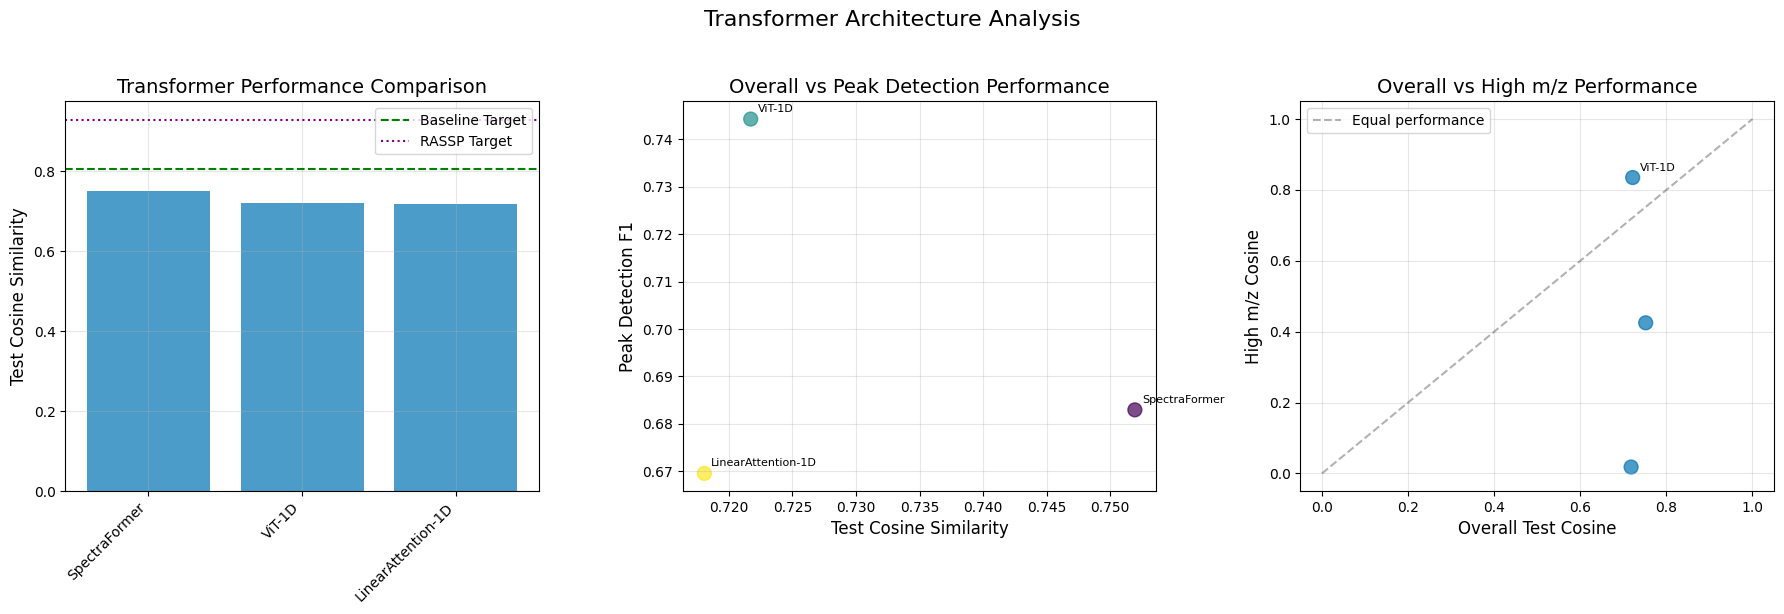


✓ Results saved to ../models/transformers\transformer_comparison.pkl

TRANSFORMER NOTEBOOK COMPLETE


In [42]:
# Collect all results
all_results = []

# List of transformer results
result_vars = [
    ('SpectraFormer', 'results_spectra'),
    ('ViT-1D', 'results_vit'),
    ('LinearAttention-1D', 'results_linear')
]

# Add transformer models
for name, var_name in result_vars:
    if var_name in locals():
        result = locals()[var_name]
        all_results.append({
            'Architecture': name,
            'Type': 'Transformer',
            'Val Cosine': result['val_cosine'],
            'Test Cosine': result['test_cosine'],
            'Test MSE': result['test_results']['mse'],
            'Peak Precision': result['test_results']['peak_metrics']['precision'],
            'Peak Recall': result['test_results']['peak_metrics']['recall'],
            'Peak F1': result['test_results']['peak_metrics']['f1_score'],
            'High m/z Cosine': np.mean([result['test_results']['mz_range_sims'][r]['mean_similarity'] 
                                       for r in list(result['test_results']['mz_range_sims'].keys())[-2:]])
        })

if all_results:
    # Create comparison dataframe
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('Test Cosine', ascending=False)
    
    print("\n" + "="*80)
    print("TRANSFORMER ARCHITECTURES - FINAL COMPARISON")
    print("="*80)
    
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(results_df.to_string(index=False))
    
    # Best model analysis
    best_model = results_df.iloc[0]
    print(f"\nBEST TRANSFORMER: {best_model['Architecture']}")
    print(f"Test Cosine Similarity: {best_model['Test Cosine']:.4f}")
    print(f"Peak Detection F1: {best_model['Peak F1']:.4f}")
    print(f"High m/z Performance: {best_model['High m/z Cosine']:.4f}")
    
    # Target analysis
    baseline_target = 0.8063
    rassp_target = 0.929
    
    print(f"\nTarget Analysis:")
    print(f"  Current best: {best_model['Test Cosine']:.4f}")
    print(f"  Baseline target: {baseline_target:.4f}")
    print(f"  Gap to baseline: {baseline_target - best_model['Test Cosine']:+.4f}")
    if best_model['Test Cosine'] > baseline_target:
        print(f"  ✓ EXCEEDED BASELINE TARGET!")
    print(f"  Gap to RASSP ({rassp_target}): {rassp_target - best_model['Test Cosine']:.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Overall performance
    ax = axes[0]
    x = np.arange(len(results_df))
    colors = ['#0072B2' for _ in results_df['Architecture']]
    bars = ax.bar(x, results_df['Test Cosine'], color=colors, alpha=0.7)
    ax.axhline(y=baseline_target, color='green', linestyle='--', label='Baseline Target')
    ax.axhline(y=rassp_target, color='purple', linestyle=':', label='RASSP Target')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Architecture'], rotation=45, ha='right')
    ax.set_ylabel('Test Cosine Similarity')
    ax.set_title('Transformer Performance Comparison')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot 2: Peak detection vs Overall performance
    ax = axes[1]
    scatter = ax.scatter(results_df['Test Cosine'], results_df['Peak F1'], 
                        s=100, alpha=0.7, c=range(len(results_df)), cmap='viridis')
    for i, row in results_df.iterrows():
        ax.annotate(row['Architecture'], 
                   (row['Test Cosine'], row['Peak F1']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax.set_xlabel('Test Cosine Similarity')
    ax.set_ylabel('Peak Detection F1')
    ax.set_title('Overall vs Peak Detection Performance')
    ax.grid(alpha=0.3)
    
    # Plot 3: High m/z performance
    ax = axes[2]
    ax.scatter(results_df['Test Cosine'], results_df['High m/z Cosine'], 
              s=100, alpha=0.7, c=colors)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal performance')
    for i, row in results_df.iterrows():
        if row['High m/z Cosine'] > row['Test Cosine'] * 0.95:
            ax.annotate(row['Architecture'], 
                       (row['Test Cosine'], row['High m/z Cosine']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax.set_xlabel('Overall Test Cosine')
    ax.set_ylabel('High m/z Cosine')
    ax.set_title('Overall vs High m/z Performance')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.suptitle('Transformer Architecture Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_path = os.path.join(CONFIG.paths.models_dir, 'transformer_comparison.pkl')
    with open(results_path, 'wb') as f:
        pickle.dump({
            'results_df': results_df,
            'all_results': all_results,
            'best_model': best_model.to_dict(),
            'config': CONFIG
        }, f)
    print(f"\n✓ Results saved to {results_path}")
else:
    print("No trained models found for comparison.")

print("\n" + "="*80)
print("TRANSFORMER NOTEBOOK COMPLETE")
print("="*80)